## The Goal: Test differences in coupling strenth between: CESM2, CESM1, CESM2/CLM4.5  
<br>
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 14 Sep 2020 <br><br>

In [2]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
#import regionmask
from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util



In [2]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


## Read in CESM2 data

In [11]:
# Load in pickle files: 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_1979-2006.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_1979-2006.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_1979-2006.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM2  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM2 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM2  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

lat = atmoLeg_CESM2.lat.values
lon = atmoLeg_CESM2.lon.values


## Read in CESM1 data
Note: These coupling indices have already been computed and saved on local laptop.

In [4]:
# Load in pickle files: 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM1.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM1.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM1.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM1  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM1 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM1  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


## Read in CESM2/CLM4.5 data
Note: This is new data, so need to compute (1) P_lcl, (2) Coupling indices [and save to file]

### Do the work of computing CI on Casper 

In [3]:
# Set directories for raw data 
cesmDir = '/glade/work/mdfowler/data/CESM2_clm4.5/'

startCLM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.'
startCAM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.'

endCLM = '_SOILWATER10CM.nc'
endFLX = '_sfcFluxes.nc'

timeName = ['1980-1989', '1990-1999', '2000-2005']



In [4]:
# Read in test file to get lat/lon 
fileName = cesmDir+startCAM+timeName[0]+endFLX
testDF   = xr.open_dataset(fileName, decode_times=True)

# Get lat and lon 
lat = testDF.lat.values
lon = testDF.lon.values 


In [5]:
# Read in flux files and get time as usable format 
file1 = cesmDir+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesmDir+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesmDir+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if __name__ == '__main__':


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


File 3 finished reading in...


In [6]:
# Read in soil moisture files and get time as usable format 
file1 = cesmDir+startCLM+timeName[0]+endCLM 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesmDir+startCLM+timeName[1]+endCLM 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesmDir+startCLM+timeName[2]+endCLM 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if __name__ == '__main__':


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


File 3 finished reading in...


In [13]:
# Sanity check method of masking negative values in Plcl.. 
a = np.asarray([[2., 3.], [-1.,4.]])
a[a<0] = np.nan
print(a)

[[ 2.  3.]
 [nan  4.]]


In [7]:
# Use newly created function to get LCL pressure
filesIn = np.asarray(['/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1980-1989_refHTs.nc',
                      '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1990-1999_refHTs.nc',
                      '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.2000-2005_refHTs.nc'])

fileOutName = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45.p'

lclPath = ComputeLCLpressure(filesIn,'PS','TREFHT','RHREFHT',fileOutName)


Number of files: 

 3


/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/ComputeLCLpressure_function.py:36: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sfcDF['time'] = sfcDF.indexes['time'].to_datetimeindex()


File 1 finished reading in...
File 2 finished reading in...
File 2 concatenated
File 3 finished reading in...
File 3 concatenated
Data starts at:  1980-01-11T00:00:00.000000000
Data ends at:    2006-01-01T00:00:00.000000000
Done with  0.0  % of days
Done with  9.998945258938932  % of days
Done with  19.997890517877863  % of days
Done with  29.996835776816795  % of days
Done with  39.995781035755726  % of days
Done with  49.99472629469465  % of days
Done with  59.99367155363359  % of days
Done with  69.99261681257252  % of days
Done with  79.99156207151145  % of days
Done with  89.99050733045037  % of days
Done with  99.9894525893893  % of days
Finished computing LCL-pressure level successfully and saved pickle file:
/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45.p


In [8]:
# Now read in Plcl from that path 
# lclPath = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45.p'
Plcl    = pickle.load( open( lclPath, "rb" ) )


In [9]:
# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(soil_full['time'].values)


In [10]:
# Read in land mask 
filePath = '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.1976-01-01-00000.nc'
exDF     = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan


### Sanity check: do variables seem okay?

Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

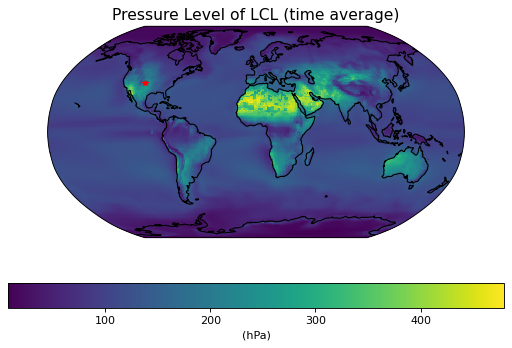

In [11]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,
                             transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)


(726619.0, 726649.0)

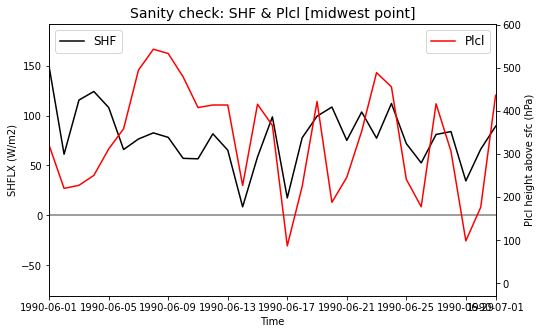

In [12]:
# Plot a timeseries of variables 

fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(dates, flux_full.SHFLX.values[:,135,206],'k-')
ax1.set_ylabel('SHFLX (W/m2)')
ax1.set_xlabel('Time')
ax1.legend(['SHF'],loc='upper left',fontsize=12)
ax1.set_title('Sanity check: SHF & Plcl [midwest point]', fontsize=14)
ax1.axhline(0,color='gray')

ax2 = ax1.twinx()
ax2.plot(dates, Plcl[:,135,206], 'r-')
ax2.set_ylabel('Plcl height above sfc (hPa)')
ax2.legend(['Plcl'], loc='upper right',fontsize=12)

ax1.set_xlim([datetime.date(1990,6,1), datetime.date(1990,7,1)])



Text(0.5, 1.0, 'LHFLX (time mean, 1979-2004)')

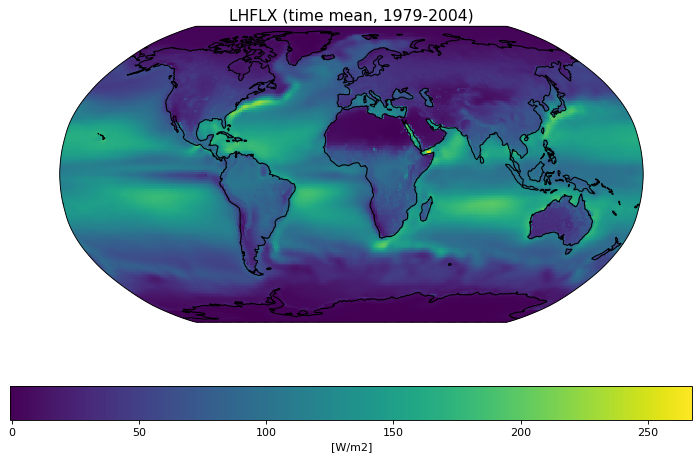

In [15]:
# How about latent heat flux? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
LHavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(flux_full.LHFLX.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,LHavg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[W/m2]',orientation='horizontal')
ax.set_title('LHFLX (time mean, 1980-2004)', fontsize=14)


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '11-cm SM (time mean, 1980-2006)')

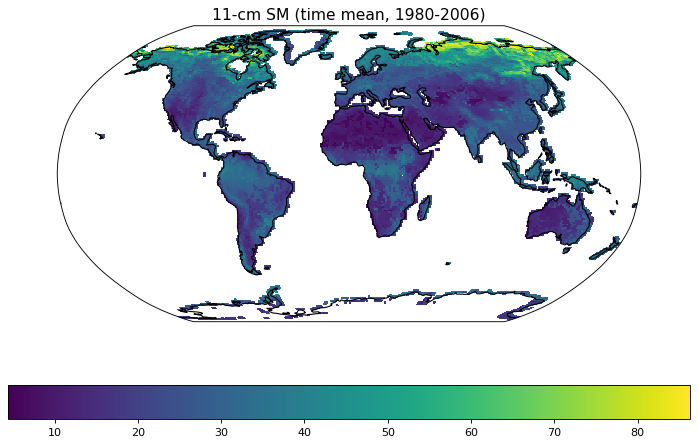

In [19]:
# How about SM? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(soil_full.SOILWATER_10CM.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,
                             SMavg_cyclic,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot,orientation='horizontal')
ax.set_title('10-cm SM (time mean, 1980-2006)', fontsize=14)


### Compute coupling index: LH & SM

In [13]:
# Make one big xr.Dataset containing all the information we need  
dFull = flux_full
dFull['soilM_10'] = (('time','lat','lon'), soil_full.SOILWATER_10CM.values)
dFull['Plcl'] = (('time','lat','lon'), Plcl)


In [14]:
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull, xname='soilM_10',yname='LHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Terrestrial Coupling Index (10cm SM and LHFLX) [DJF]')

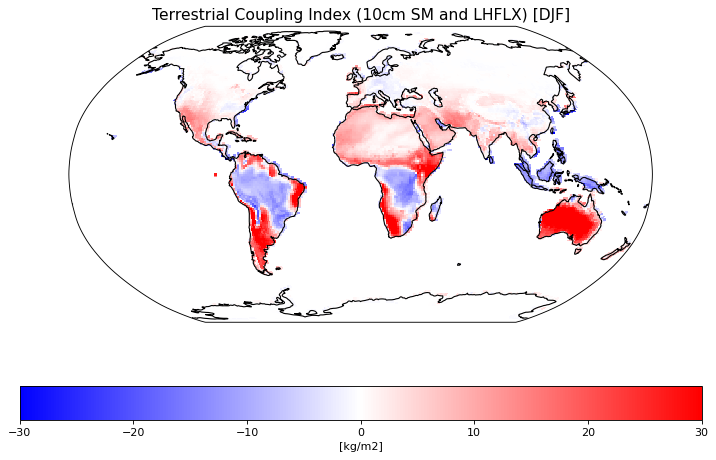

In [15]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
terraCoupl_DJF, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(terra_coupling.soilM_10_LHFLX_CI[0,:,:]), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,terraCoupl_DJF,vmin=-30,vmax=30,cmap='bwr',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[kg/m2]',orientation='horizontal')
ax.set_title('Terrestrial Coupling Index (10cm SM and LHFLX) ['+np.asarray(terra_coupling.season)[0]+']', fontsize=14)



### Compute coupling indices: SH, SM, and P_lcl

In [16]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling = cm.metrics.CouplingIndex()
terraLeg_coupling = terraLeg_coupling.compute(dFull, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terraLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc')



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [17]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling = cm.metrics.CouplingIndex()
atmoLeg_coupling = atmoLeg_coupling.compute(dFull, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file 
atmoLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Read in from files

In [5]:
# Load in pickle files: 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CLM45  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CLM45 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CLM45  = xr.open_dataset(dataDir+file_LH,      decode_times=False)



## Read in CESM2/CAM5 data
Note: This is new data, so need to compute (1) P_lcl, (2) Coupling indices [and save to file]

### Again, compute on Casper

In [18]:
# Set directories for raw data 
cesmDir = '/glade/work/mdfowler/data/CESM2_cam5/'

startCLM = 'f.e20.FHIST.f09_f09.cesm2_1_cam5.001.clm2.h0.'
startCAM = 'f.e20.FHIST.f09_f09.cesm2_1_cam5.001.cam.h0.'

endCLM = '_SOILWATER10.nc'
endFLX = '_sfcFluxes.nc'

#timeName = ['1980-1989', '1990-1999', '2000-2006']


In [19]:
# Read in test file to get lat/lon 
fileName = cesmDir+startCAM+timeName[0]+endFLX
testDF   = xr.open_dataset(fileName, decode_times=True)

# Get lat and lon 
lat = testDF.lat.values
lon = testDF.lon.values 


In [21]:
# Read in flux files and get time as usable format 
timeName = ['1980-1989', '1990-1999', '2000-2006']

file1 = cesmDir+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesmDir+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesmDir+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # This is added back by InteractiveShellApp.init_path()


File 1 finished reading in...
File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  app.launch_new_instance()


File 3 finished reading in...


In [22]:
# Read in soil moisture files and get time as usable format 
timeName = ['1980-1989', '1990-1999', '2000-2005']

file1 = cesmDir+startCLM+timeName[0]+endCLM 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesmDir+startCLM+timeName[1]+endCLM 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesmDir+startCLM+timeName[2]+endCLM 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # This is added back by InteractiveShellApp.init_path()
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard cale

File 1 finished reading in...
File 2 finished reading in...
File 3 finished reading in...


In [23]:
# Use newly created function to get LCL pressure
filesIn = np.asarray(['/glade/work/mdfowler/data/CESM2_cam5/f.e20.FHIST.f09_f09.cesm2_1_cam5.001.cam.h0.1980-1989_refHTs_RHREFHT.nc',
                      '/glade/work/mdfowler/data/CESM2_cam5/f.e20.FHIST.f09_f09.cesm2_1_cam5.001.cam.h0.1990-1999_refHTs_RHREFHT.nc',
                      '/glade/work/mdfowler/data/CESM2_cam5/f.e20.FHIST.f09_f09.cesm2_1_cam5.001.cam.h0.2000-2005_refHTs_RHREFHT.nc'])

fileOutName = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CAM5.p'

lclPath = ComputeLCLpressure(filesIn,'PS','TREFHT','RHREFHT',fileOutName)


Number of files: 

 3
File 1 finished reading in...


/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/ComputeLCLpressure_function.py:36: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sfcDF['time'] = sfcDF.indexes['time'].to_datetimeindex()


File 2 finished reading in...
File 2 concatenated
File 3 finished reading in...
File 3 concatenated
Data starts at:  1980-02-01T00:00:00.000000000
Data ends at:    2006-01-01T00:00:00.000000000
Done with  0.0  % of days
Done with  9.935897435897436  % of days
Done with  19.871794871794872  % of days
Done with  29.807692307692307  % of days
Done with  39.743589743589745  % of days
Done with  49.67948717948718  % of days
Done with  59.61538461538461  % of days
Done with  69.55128205128204  % of days
Done with  79.48717948717949  % of days
Done with  89.42307692307693  % of days
Done with  99.35897435897436  % of days
Finished computing LCL-pressure level successfully and saved pickle file:
/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CAM5.p


In [24]:
# Now read in Plcl from that path 
Plcl    = pickle.load( open( lclPath, "rb" ) )


In [25]:
np.shape(Plcl)

(312, 192, 288)

In [26]:
# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(soil_full['time'].values)


In [27]:
# Read in land mask (same grid as before...) 
filePath = '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.1976-01-01-00000.nc'
exDF     = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan



### Did RH calculation work?
It at least seems to have... values look pretty reasonable to me. 

In [28]:
cam5_file = '/glade/work/mdfowler/data/CESM2_cam5/f.e20.FHIST.f09_f09.cesm2_1_cam5.001.cam.h0.1980-1989_refHTs_RHREFHT.nc'
cam5_DF = xr.open_dataset(cam5_file, decode_times=True)

clm45_file = '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1980-1989_refHTs.nc'
clm45_DF  = xr.open_dataset(clm45_file, decode_times=True)

cam5_DF

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * time     (time) object 1980-02-01 00:00:00 ... 1990-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    RHREFHT  (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    PS       (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
Attributes:
    creation_date:  Mon Sep 14 14:24:15 MDT 2020
    Conventions:    None
    source_file:    /glade/work/mdfowler/data/CESM2_cam5/f.e20.FHIST.f09_f09....
    title:          NCL used to compute RHREFHT from QREFHT, TREFHT, and PS.

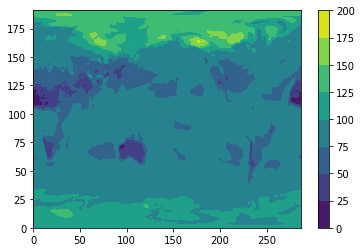

In [29]:
plt.contourf(cam5_DF.RHREFHT[10,:,:])
plt.colorbar()

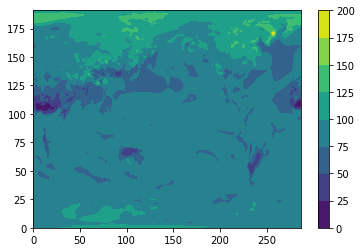

In [30]:
plt.contourf(clm45_DF.RHREFHT[10,:,:])
plt.colorbar()

### Sanity check variables

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

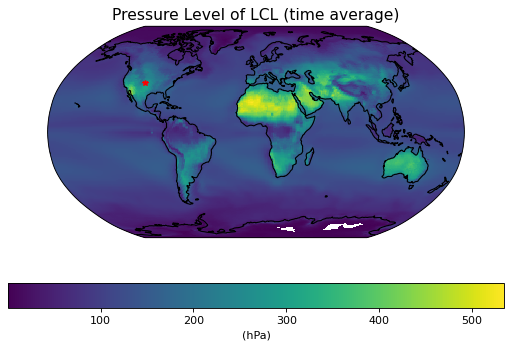

In [31]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)


(726468.0, 728659.0)

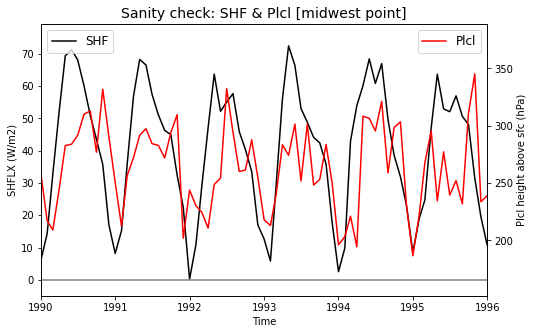

In [32]:
# Plot a timeseries of variables 

fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(dates, flux_full.SHFLX.values[:,135,206],'k-')
ax1.set_ylabel('SHFLX (W/m2)')
ax1.set_xlabel('Time')
ax1.legend(['SHF'],loc='upper left',fontsize=12)
ax1.set_title('Sanity check: SHF & Plcl [midwest point]', fontsize=14)
ax1.axhline(0,color='gray')

ax2 = ax1.twinx()
ax2.plot(dates, Plcl[:,135,206], 'r-')
ax2.set_ylabel('Plcl height above sfc (hPa)')
ax2.legend(['Plcl'], loc='upper right',fontsize=12)

ax1.set_xlim([datetime.date(1990,1,1), datetime.date(1996,1,1)])


Text(0.5, 1.0, 'LHFLX (time mean, 1980-2004)')

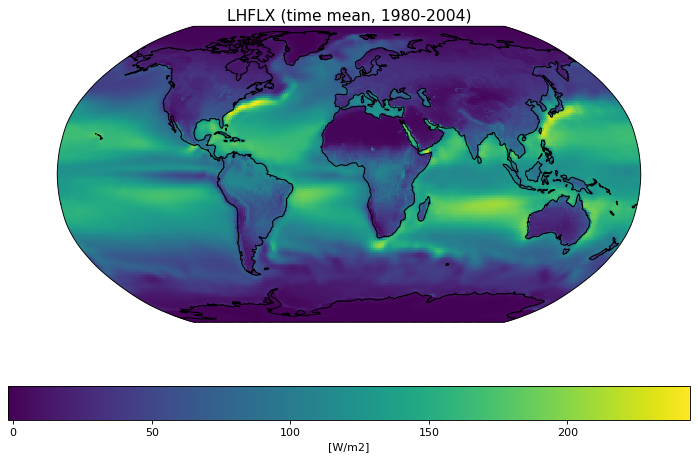

In [33]:
# How about latent heat flux? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
LHavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(flux_full.LHFLX.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,LHavg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[W/m2]',orientation='horizontal')
ax.set_title('LHFLX (time mean, 1980-2004)', fontsize=14)


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '10-cm SM (time mean, 1980-2006)')

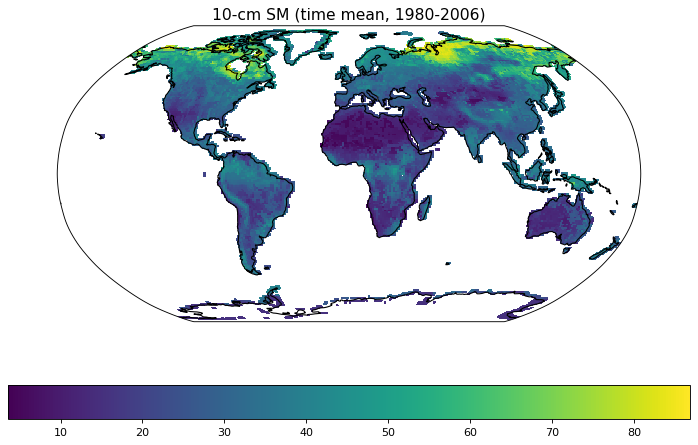

In [34]:
# How about SM? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(soil_full.SOILWATER_10CM.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,
                             SMavg_cyclic,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot,orientation='horizontal')
ax.set_title('10-cm SM (time mean, 1980-2006)', fontsize=14)


### Compute coupling index: LH & SM

In [35]:
# Make one big xr.Dataset containing all the information we need  
dFull = flux_full
dFull['soilM_10'] = (('time','lat','lon'), soil_full.SOILWATER_10CM.values)
dFull['Plcl'] = (('time','lat','lon'), Plcl)


In [36]:
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull, xname='soilM_10',yname='LHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_CESM2-CAM5.nc')

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Terrestrial Coupling Index (10cm SM and LHFLX) [DJF]')

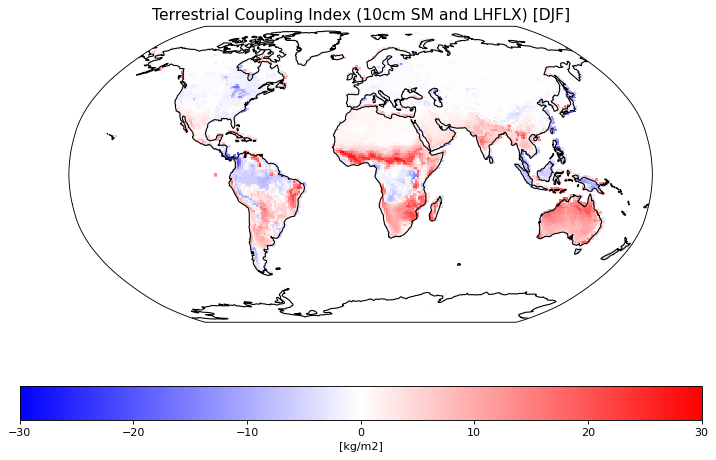

In [37]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
terraCoupl_DJF, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(terra_coupling.soilM_10_LHFLX_CI[0,:,:]), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,terraCoupl_DJF,vmin=-30,vmax=30,cmap='bwr',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[kg/m2]',orientation='horizontal')
ax.set_title('Terrestrial Coupling Index (10cm SM and LHFLX) ['+np.asarray(terra_coupling.season)[0]+']', fontsize=14)


### Compute coupling index: SH, SM, and P_lcl

In [38]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling = cm.metrics.CouplingIndex()
terraLeg_coupling = terraLeg_coupling.compute(dFull, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terraLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CESM2-CAM5.nc')

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [39]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling = cm.metrics.CouplingIndex()
atmoLeg_coupling = atmoLeg_coupling.compute(dFull, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file 
atmoLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CESM2-CAM5.nc')

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Read in from files 

In [7]:
# Load in pickle files: 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CAM5.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CAM5.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CAM5.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM5  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM5 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM5  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


## Now plot some comparisons

### Set up color maps 

In [8]:
### Create a list of RGB tuples
colorsList_SMvLHF = [(127,58,144), 
                     (67,81,163),
                     (0,191,243),
                     (194,229,220),
                     (124,194,66),
                     (227,219,46),
                     (250,175,44),
                     (245,127,36), 
                     (239,67,54),
                     (238,45,122),
                     (162,6,66)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap_SMvLHF = make_cmap(colorsList_SMvLHF, bit=True)



### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)



### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)


### Plots for LH-SM coupling index

In [9]:
lat = terraLH_CESM2.lat.values
lon = terraLH_CESM2.lon.values

In [11]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
LHcoupl_JJA_cesm1 = np.squeeze(np.asarray(terraLH_CESM1.soilM_10_LHFLX_CI[1,:,:]))
LHcoupl_DJF_cesm1 = np.squeeze(np.asarray(terraLH_CESM1.soilM_10_LHFLX_CI[0,:,:]))
LHcoupl_JJA_cesm2 = np.squeeze(np.asarray(terraLH_CESM2.mrsos_hfls_CI[1,:,:]))
LHcoupl_DJF_cesm2 = np.squeeze(np.asarray(terraLH_CESM2.mrsos_hfls_CI[0,:,:]))
LHcoupl_JJA_clm45 = np.squeeze(np.asarray(terraLH_CLM45.soilM_10_LHFLX_CI[1,:,:]))
LHcoupl_DJF_clm45 = np.squeeze(np.asarray(terraLH_CLM45.soilM_10_LHFLX_CI[0,:,:]))
LHcoupl_JJA_cam5 = np.squeeze(np.asarray(terraLH_CAM5.soilM_10_LHFLX_CI[1,:,:]))
LHcoupl_DJF_cam5 = np.squeeze(np.asarray(terraLH_CAM5.soilM_10_LHFLX_CI[0,:,:]))

# Make cyclic first 
LHcoupl_JJA_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA_cesm1, lon)
LHcoupl_DJF_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF_cesm1, lon)
LHcoupl_JJA_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA_cesm2, lon)
LHcoupl_DJF_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF_cesm2, lon)
LHcoupl_JJA_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA_clm45, lon)
LHcoupl_DJF_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF_clm45, lon)
LHcoupl_JJA_cyclic_cam5, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA_cam5, lon)
LHcoupl_DJF_cyclic_cam5, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF_cam5, lon)

# Now get color coded arrays 
colorsSMvLHF_JJA_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_JJA_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_JJA_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_JJA_cam5 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF_cam5 = np.full([len(lat),len(lon)+1],np.nan)


# ----- CESM 1 ---------

# JJA 
colorsSMvLHF_JJA_cesm1[np.where(LHcoupl_JJA_cyclic_cesm1<-15)]                                = 1
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-15) & (LHcoupl_JJA_cyclic_cesm1<=-10))]  = 2
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-10) & (LHcoupl_JJA_cyclic_cesm1<=-5))]   = 3
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-5)  & (LHcoupl_JJA_cyclic_cesm1<=5))]    = 4
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>5)   & (LHcoupl_JJA_cyclic_cesm1<=10))]   = 5
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>10)  & (LHcoupl_JJA_cyclic_cesm1<=15))]   = 6
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>15)  & (LHcoupl_JJA_cyclic_cesm1<=20))]   = 7
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>20)  & (LHcoupl_JJA_cyclic_cesm1<=25))]   = 8
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>25)  & (LHcoupl_JJA_cyclic_cesm1<=30))]   = 9
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>30)  & (LHcoupl_JJA_cyclic_cesm1<=35))]   = 10
colorsSMvLHF_JJA_cesm1[np.where(LHcoupl_JJA_cyclic_cesm1>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF_cesm1[np.where(LHcoupl_DJF_cyclic_cesm1<-15)]                                = 1
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>-15) & (LHcoupl_DJF_cyclic_cesm1<=-10))]  = 2
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>-10) & (LHcoupl_DJF_cyclic_cesm1<=-5))]   = 3
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>-5)  & (LHcoupl_DJF_cyclic_cesm1<=5))]    = 4
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>5)   & (LHcoupl_DJF_cyclic_cesm1<=10))]   = 5
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>10)  & (LHcoupl_DJF_cyclic_cesm1<=15))]   = 6
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>15)  & (LHcoupl_DJF_cyclic_cesm1<=20))]   = 7
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>20)  & (LHcoupl_DJF_cyclic_cesm1<=25))]   = 8
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>25)  & (LHcoupl_DJF_cyclic_cesm1<=30))]   = 9
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>30)  & (LHcoupl_DJF_cyclic_cesm1<=35))]   = 10
colorsSMvLHF_DJF_cesm1[np.where(LHcoupl_DJF_cyclic_cesm1>35)]                                 = 11


# ----- CESM 2 ---------

# JJA 
colorsSMvLHF_JJA_cesm2[np.where(LHcoupl_JJA_cyclic_cesm2<-15)]                                = 1
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>-15) & (LHcoupl_JJA_cyclic_cesm2<=-10))]  = 2
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>-10) & (LHcoupl_JJA_cyclic_cesm2<=-5))]   = 3
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>-5)  & (LHcoupl_JJA_cyclic_cesm2<=5))]    = 4
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>5)   & (LHcoupl_JJA_cyclic_cesm2<=10))]   = 5
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>10)  & (LHcoupl_JJA_cyclic_cesm2<=15))]   = 6
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>15)  & (LHcoupl_JJA_cyclic_cesm2<=20))]   = 7
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>20)  & (LHcoupl_JJA_cyclic_cesm2<=25))]   = 8
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>25)  & (LHcoupl_JJA_cyclic_cesm2<=30))]   = 9
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>30)  & (LHcoupl_JJA_cyclic_cesm2<=35))]   = 10
colorsSMvLHF_JJA_cesm2[np.where(LHcoupl_JJA_cyclic_cesm2>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF_cesm2[np.where(LHcoupl_DJF_cyclic_cesm2<-15)]                                = 1
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>-15) & (LHcoupl_DJF_cyclic_cesm2<=-10))]  = 2
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>-10) & (LHcoupl_DJF_cyclic_cesm2<=-5))]   = 3
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>-5)  & (LHcoupl_DJF_cyclic_cesm2<=5))]    = 4
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>5)   & (LHcoupl_DJF_cyclic_cesm2<=10))]   = 5
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>10)  & (LHcoupl_DJF_cyclic_cesm2<=15))]   = 6
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>15)  & (LHcoupl_DJF_cyclic_cesm2<=20))]   = 7
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>20)  & (LHcoupl_DJF_cyclic_cesm2<=25))]   = 8
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>25)  & (LHcoupl_DJF_cyclic_cesm2<=30))]   = 9
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>30)  & (LHcoupl_DJF_cyclic_cesm2<=35))]   = 10
colorsSMvLHF_DJF_cesm2[np.where(LHcoupl_DJF_cyclic_cesm2>35)]                                 = 11


# ----- CLM4.5 (+ CAM6) ---------

# JJA 
colorsSMvLHF_JJA_clm45[np.where(LHcoupl_JJA_cyclic_clm45<-15)]                                = 1
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>-15) & (LHcoupl_JJA_cyclic_clm45<=-10))]  = 2
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>-10) & (LHcoupl_JJA_cyclic_clm45<=-5))]   = 3
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>-5)  & (LHcoupl_JJA_cyclic_clm45<=5))]    = 4
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>5)   & (LHcoupl_JJA_cyclic_clm45<=10))]   = 5
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>10)  & (LHcoupl_JJA_cyclic_clm45<=15))]   = 6
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>15)  & (LHcoupl_JJA_cyclic_clm45<=20))]   = 7
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>20)  & (LHcoupl_JJA_cyclic_clm45<=25))]   = 8
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>25)  & (LHcoupl_JJA_cyclic_clm45<=30))]   = 9
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>30)  & (LHcoupl_JJA_cyclic_clm45<=35))]   = 10
colorsSMvLHF_JJA_clm45[np.where(LHcoupl_JJA_cyclic_clm45>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF_clm45[np.where(LHcoupl_DJF_cyclic_clm45<-15)]                                = 1
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>-15) & (LHcoupl_DJF_cyclic_clm45<=-10))]  = 2
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>-10) & (LHcoupl_DJF_cyclic_clm45<=-5))]   = 3
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>-5)  & (LHcoupl_DJF_cyclic_clm45<=5))]    = 4
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>5)   & (LHcoupl_DJF_cyclic_clm45<=10))]   = 5
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>10)  & (LHcoupl_DJF_cyclic_clm45<=15))]   = 6
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>15)  & (LHcoupl_DJF_cyclic_clm45<=20))]   = 7
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>20)  & (LHcoupl_DJF_cyclic_clm45<=25))]   = 8
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>25)  & (LHcoupl_DJF_cyclic_clm45<=30))]   = 9
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>30)  & (LHcoupl_DJF_cyclic_clm45<=35))]   = 10
colorsSMvLHF_DJF_clm45[np.where(LHcoupl_DJF_cyclic_clm45>35)]                                 = 11


# ----- CAM5 (+ CLM5) ---------

# JJA 
colorsSMvLHF_JJA_cam5[np.where(LHcoupl_JJA_cyclic_cam5<-15)]                                = 1
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>-15) & (LHcoupl_JJA_cyclic_cam5<=-10))]  = 2
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>-10) & (LHcoupl_JJA_cyclic_cam5<=-5))]   = 3
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>-5)  & (LHcoupl_JJA_cyclic_cam5<=5))]    = 4
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>5)   & (LHcoupl_JJA_cyclic_cam5<=10))]   = 5
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>10)  & (LHcoupl_JJA_cyclic_cam5<=15))]   = 6
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>15)  & (LHcoupl_JJA_cyclic_cam5<=20))]   = 7
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>20)  & (LHcoupl_JJA_cyclic_cam5<=25))]   = 8
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>25)  & (LHcoupl_JJA_cyclic_cam5<=30))]   = 9
colorsSMvLHF_JJA_cam5[np.where((LHcoupl_JJA_cyclic_cam5>30)  & (LHcoupl_JJA_cyclic_cam5<=35))]   = 10
colorsSMvLHF_JJA_cam5[np.where(LHcoupl_JJA_cyclic_cam5>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF_cam5[np.where(LHcoupl_DJF_cyclic_cam5<-15)]                                = 1
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>-15) & (LHcoupl_DJF_cyclic_cam5<=-10))]  = 2
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>-10) & (LHcoupl_DJF_cyclic_cam5<=-5))]   = 3
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>-5)  & (LHcoupl_DJF_cyclic_cam5<=5))]    = 4
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>5)   & (LHcoupl_DJF_cyclic_cam5<=10))]   = 5
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>10)  & (LHcoupl_DJF_cyclic_cam5<=15))]   = 6
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>15)  & (LHcoupl_DJF_cyclic_cam5<=20))]   = 7
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>20)  & (LHcoupl_DJF_cyclic_cam5<=25))]   = 8
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>25)  & (LHcoupl_DJF_cyclic_cam5<=30))]   = 9
colorsSMvLHF_DJF_cam5[np.where((LHcoupl_DJF_cyclic_cam5>30)  & (LHcoupl_DJF_cyclic_cam5<=35))]   = 10
colorsSMvLHF_DJF_cam5[np.where(LHcoupl_DJF_cyclic_cam5>35)]                                 = 11


<ipython-input-11-86ee63e88a5a>:37: RuntimeWarning: invalid value encountered in less
  colorsSMvLHF_JJA_cesm1[np.where(LHcoupl_JJA_cyclic_cesm1<-15)]                                = 1
<ipython-input-11-86ee63e88a5a>:38: RuntimeWarning: invalid value encountered in greater
  colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-15) & (LHcoupl_JJA_cyclic_cesm1<=-10))]  = 2
<ipython-input-11-86ee63e88a5a>:38: RuntimeWarning: invalid value encountered in less_equal
  colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-15) & (LHcoupl_JJA_cyclic_cesm1<=-10))]  = 2
<ipython-input-11-86ee63e88a5a>:39: RuntimeWarning: invalid value encountered in greater
  colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-10) & (LHcoupl_JJA_cyclic_cesm1<=-5))]   = 3
<ipython-input-11-86ee63e88a5a>:39: RuntimeWarning: invalid value encountered in less_equal
  colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-10) & (LHcoupl_JJA_cyclic_cesm1<=-5))]   = 3
<ipython-input-11-86ee63e88a

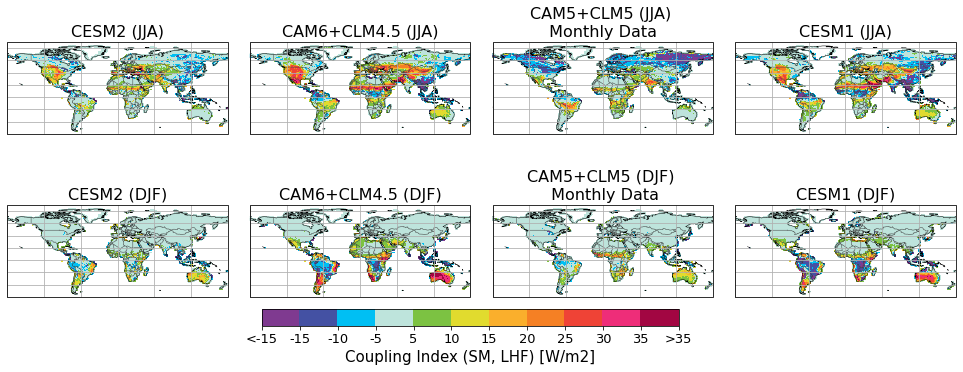

In [10]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.4,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()
# Set up color options 
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA_cesm2,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF_cesm2,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CESM2 (JJA)',fontsize=16)
axs[4].set_title('CESM2 (DJF)',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA_clm45,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

contour_plot = axs[5].pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF_clm45,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Additional options 
axs[1].set_title('CAM6+CLM4.5 (JJA)',fontsize=16)
axs[5].set_title('CAM6+CLM4.5 (DJF)',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, LHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-15','-15','-10','-5','5','10', '15','20','25','30','35','>35'],fontsize=13)  # vertically oriented colorbar




# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA_cam5,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

contour_plot = axs[6].pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF_cam5,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Additional options 
axs[2].set_title('CAM5+CLM5 (JJA) \n Monthly Data ',fontsize=16)
axs[6].set_title('CAM5+CLM5 (DJF) \n Monthly Data',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA_cesm1,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

contour_plot = axs[7].pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF_cesm1,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Additional options 
axs[3].set_title('CESM1 (JJA)',fontsize=16)
axs[7].set_title('CESM1 (DJF)',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



### Plots of SM, SHFLX, P_lcl coupling

In [13]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
AtmoLeg_JJA_cesm1  = np.squeeze(np.asarray(atmoLeg_CESM1.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm1 = np.squeeze(np.asarray(terraLeg_CESM1.soilM_10_SHFLX_CI[1,:,:]))
AtmoLeg_JJA_cesm2  = np.squeeze(np.asarray(atmoLeg_CESM2.hfss_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm2 = np.squeeze(np.asarray(terraLeg_CESM2.mrsos_hfss_CI[1,:,:]))
AtmoLeg_JJA_clm45  = np.squeeze(np.asarray(atmoLeg_CLM45.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm45 = np.squeeze(np.asarray(terraLeg_CLM45.soilM_10_SHFLX_CI[1,:,:]))
AtmoLeg_JJA_cam5   = np.squeeze(np.asarray(atmoLeg_CAM5.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_cam5  = np.squeeze(np.asarray(terraLeg_CAM5.soilM_10_SHFLX_CI[1,:,:]))

# Make cyclic first 
AtmoLeg_JJA_cyclic_cesm1, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm1, lon)
TerraLeg_JJA_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm1, lon)
AtmoLeg_JJA_cyclic_cesm2, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm2, lon)
TerraLeg_JJA_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm2, lon)
AtmoLeg_JJA_cyclic_clm45, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_clm45, lon)
TerraLeg_JJA_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_clm45, lon)
AtmoLeg_JJA_cyclic_cam5, lon_cyclic   = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cam5, lon)
TerraLeg_JJA_cyclic_cam5, lon_cyclic  = cartopy.util.add_cyclic_point(TerraLeg_JJA_cam5, lon)


# Now get color coded arrays 
colorsAtmoLeg_cesm1  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cesm2  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_clm45  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cam5   = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cam5  = np.full([len(lat),len(lon)+1],np.nan)

# ----- CESM 1 ------

# Atmo leg 
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1<-150)]                                 = 1
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-150) & (AtmoLeg_JJA_cyclic_cesm1<=-100))]  = 2
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-100) & (AtmoLeg_JJA_cyclic_cesm1<=-50))]   = 3
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-50)  & (AtmoLeg_JJA_cyclic_cesm1<=-20))]   = 4
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-20)  & (AtmoLeg_JJA_cyclic_cesm1<=0))]     = 5
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>0)    & (AtmoLeg_JJA_cyclic_cesm1<=20))]    = 6
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>20)   & (AtmoLeg_JJA_cyclic_cesm1<=40))]    = 7
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>40)   & (AtmoLeg_JJA_cyclic_cesm1<=60))]    = 8
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>60)   & (AtmoLeg_JJA_cyclic_cesm1<=80))]    = 9
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>80)   & (AtmoLeg_JJA_cyclic_cesm1<=100))]   = 10
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1<-20)]                                 = 1
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-20) & (TerraLeg_JJA_cyclic_cesm1<=-15))]  = 2
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-15) & (TerraLeg_JJA_cyclic_cesm1<=-10))]  = 3
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-10) & (TerraLeg_JJA_cyclic_cesm1<=-5))]   = 4
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-5) & (TerraLeg_JJA_cyclic_cesm1<=-2))]    = 5
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-2) & (TerraLeg_JJA_cyclic_cesm1<=-1))]    = 6
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-1) & (TerraLeg_JJA_cyclic_cesm1<=0))]     = 7
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1>0)]                                   = 8


# ----- CESM 2 ------

# Atmo leg 
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2<-150)]                                 = 1
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-150) & (AtmoLeg_JJA_cyclic_cesm2<=-100))]  = 2
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-100) & (AtmoLeg_JJA_cyclic_cesm2<=-50))]   = 3
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-50)  & (AtmoLeg_JJA_cyclic_cesm2<=-20))]   = 4
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-20)  & (AtmoLeg_JJA_cyclic_cesm2<=0))]     = 5
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>0)    & (AtmoLeg_JJA_cyclic_cesm2<=20))]    = 6
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>20)   & (AtmoLeg_JJA_cyclic_cesm2<=40))]    = 7
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>40)   & (AtmoLeg_JJA_cyclic_cesm2<=60))]    = 8
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>60)   & (AtmoLeg_JJA_cyclic_cesm2<=80))]    = 9
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>80)   & (AtmoLeg_JJA_cyclic_cesm2<=100))]   = 10
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2<-20)]                                 = 1
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-20) & (TerraLeg_JJA_cyclic_cesm2<=-15))]  = 2
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-15) & (TerraLeg_JJA_cyclic_cesm2<=-10))]  = 3
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-10) & (TerraLeg_JJA_cyclic_cesm2<=-5))]   = 4
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-5) & (TerraLeg_JJA_cyclic_cesm2<=-2))]    = 5
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-2) & (TerraLeg_JJA_cyclic_cesm2<=-1))]    = 6
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-1) & (TerraLeg_JJA_cyclic_cesm2<=0))]     = 7
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2>0)]                                   = 8



# ----- CLM4.5 ------

# Atmo leg 
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45<-150)]                                 = 1
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-150) & (AtmoLeg_JJA_cyclic_clm45<=-100))]  = 2
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-100) & (AtmoLeg_JJA_cyclic_clm45<=-50))]   = 3
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-50)  & (AtmoLeg_JJA_cyclic_clm45<=-20))]   = 4
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-20)  & (AtmoLeg_JJA_cyclic_clm45<=0))]     = 5
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>0)    & (AtmoLeg_JJA_cyclic_clm45<=20))]    = 6
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>20)   & (AtmoLeg_JJA_cyclic_clm45<=40))]    = 7
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>40)   & (AtmoLeg_JJA_cyclic_clm45<=60))]    = 8
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>60)   & (AtmoLeg_JJA_cyclic_clm45<=80))]    = 9
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>80)   & (AtmoLeg_JJA_cyclic_clm45<=100))]   = 10
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45>100)]                                  = 11


# Terra leg  
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45<-20)]                                 = 1
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-20) & (TerraLeg_JJA_cyclic_clm45<=-15))]  = 2
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-15) & (TerraLeg_JJA_cyclic_clm45<=-10))]  = 3
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-10) & (TerraLeg_JJA_cyclic_clm45<=-5))]   = 4
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-5) & (TerraLeg_JJA_cyclic_clm45<=-2))]    = 5
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-2) & (TerraLeg_JJA_cyclic_clm45<=-1))]    = 6
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-1) & (TerraLeg_JJA_cyclic_clm45<=0))]     = 7
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45>0)]                                   = 8



# ----- CAM5 ------

# Atmo leg 
colorsAtmoLeg_cam5[np.where(AtmoLeg_JJA_cyclic_cam5<-150)]                                 = 1
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-150) & (AtmoLeg_JJA_cyclic_cam5<=-100))]  = 2
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-100) & (AtmoLeg_JJA_cyclic_cam5<=-50))]   = 3
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-50)  & (AtmoLeg_JJA_cyclic_cam5<=-20))]   = 4
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-20)  & (AtmoLeg_JJA_cyclic_cam5<=0))]     = 5
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>0)    & (AtmoLeg_JJA_cyclic_cam5<=20))]    = 6
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>20)   & (AtmoLeg_JJA_cyclic_cam5<=40))]    = 7
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>40)   & (AtmoLeg_JJA_cyclic_cam5<=60))]    = 8
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>60)   & (AtmoLeg_JJA_cyclic_cam5<=80))]    = 9
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>80)   & (AtmoLeg_JJA_cyclic_cam5<=100))]   = 10
colorsAtmoLeg_cam5[np.where(AtmoLeg_JJA_cyclic_cam5>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cam5[np.where(TerraLeg_JJA_cyclic_cam5<-20)]                                 = 1
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-20) & (TerraLeg_JJA_cyclic_cam5<=-15))]  = 2
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-15) & (TerraLeg_JJA_cyclic_cam5<=-10))]  = 3
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-10) & (TerraLeg_JJA_cyclic_cam5<=-5))]   = 4
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-5) & (TerraLeg_JJA_cyclic_cam5<=-2))]    = 5
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-2) & (TerraLeg_JJA_cyclic_cam5<=-1))]    = 6
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-1) & (TerraLeg_JJA_cyclic_cam5<=0))]     = 7
colorsTerraLeg_cam5[np.where(TerraLeg_JJA_cyclic_cam5>0)]                                   = 8


<ipython-input-13-5436ad6f1d9d>:51: RuntimeWarning: invalid value encountered in less
  colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1<-20)]                                 = 1
<ipython-input-13-5436ad6f1d9d>:52: RuntimeWarning: invalid value encountered in greater
  colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-20) & (TerraLeg_JJA_cyclic_cesm1<=-15))]  = 2
<ipython-input-13-5436ad6f1d9d>:52: RuntimeWarning: invalid value encountered in less_equal
  colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-20) & (TerraLeg_JJA_cyclic_cesm1<=-15))]  = 2
<ipython-input-13-5436ad6f1d9d>:53: RuntimeWarning: invalid value encountered in greater
  colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-15) & (TerraLeg_JJA_cyclic_cesm1<=-10))]  = 3
<ipython-input-13-5436ad6f1d9d>:53: RuntimeWarning: invalid value encountered in less_equal
  colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-15) & (TerraLeg_JJA_cyclic_cesm1<=-10))]  = 3
<ipython-input-13-5436ad6f1d

In [14]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask = np.full([len(lat),len(lon)+1],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_JJA_cyclic_cesm1))] = 1


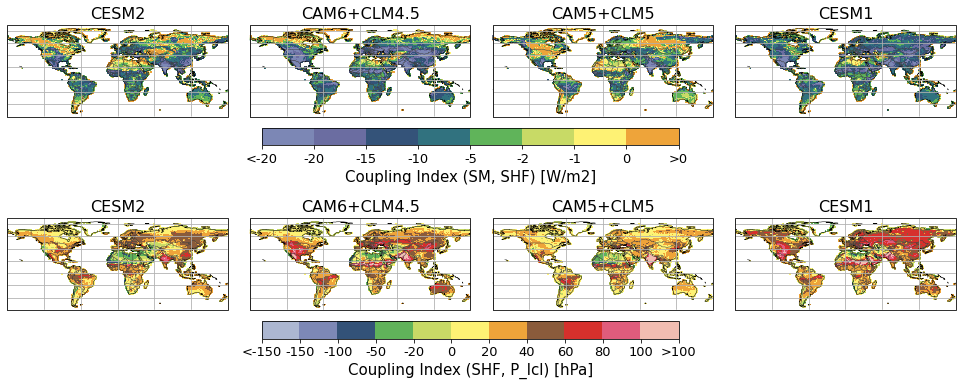

In [13]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsTerraLeg_clm45,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=13)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_clm45*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=15)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=13)  # vertically oriented colorbar


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[5].set_title('CAM6+CLM4.5',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cam5,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[6].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cam5*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[6].set_title('CAM5+CLM5',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm1,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm1*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[7].set_title('CESM1',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


## Difference plots

In [12]:
atmoDiff_CESM2vCESM1 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_cesm1  # Impact of upgrading CAM and CLM 
atmoDiff_CESM2vCLM45 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_clm45  # Impact of upgrading CAM 
atmoDiff_CESM2vCAM5  = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_cam5   # Impact of upgrading CLM 

terraDiff_CESM2vCESM1 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_cesm1 # Impact of upgrading CAM and CLM  
terraDiff_CESM2vCLM45 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_clm45 # Impact of upgrading CAM 
terraDiff_CESM2vCAM5  = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_cam5  # Impact of upgrading CLM 



NameError: name 'AtmoLeg_JJA_cyclic_cesm2' is not defined

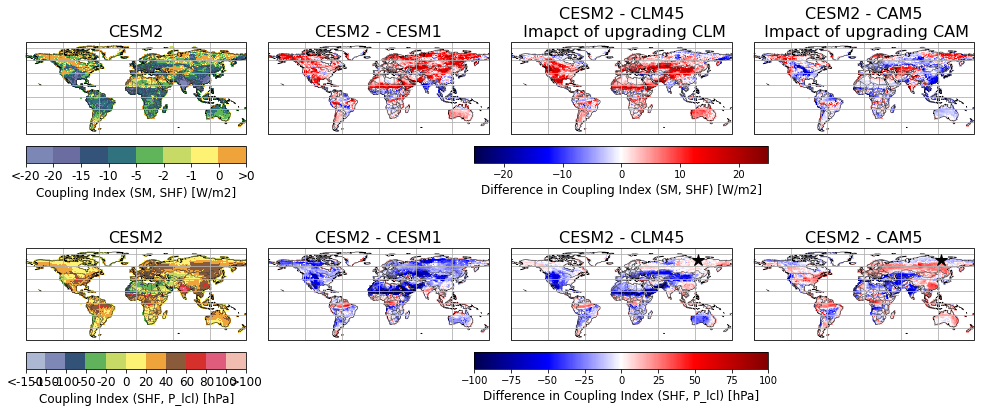

In [77]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=12)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=12)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=12)  # vertically oriented colorbar


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-25,vmax=25)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-25,vmax=25)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SM, SHF) [W/m2]',fontsize=12)


contour_plot = axs[6].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Add colorbar 
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
#   ...Diff_CESM2vCAM5
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCAM5,
                             cmap='seismic',
                             vmin=-25,vmax=25)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCAM5*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[7].set_title('CESM2 - CAM5',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Add star point 
axs[6].plot(lon[100],lat[170],'k*',markersize=12,transform=ccrs.PlateCarree())
axs[7].plot(lon[100],lat[170],'k*',markersize=12,transform=ccrs.PlateCarree())


## Pick out interesting locations

Isla's suggestion seems really good - how about a place where CLM seems to dominate, a place where CAM seems to dominate, a place where things are vs. are not additive? 

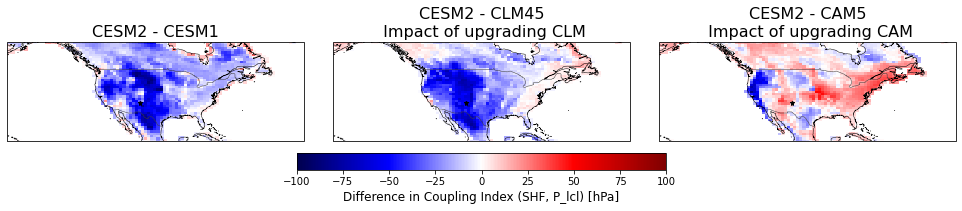

In [146]:
## Atmospheric leg 
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Zoom in on NH
axs[0].set_extent([-160,-40,20,60], crs=ccrs.PlateCarree())  
axs[1].set_extent([-160,-40,20,60], crs=ccrs.PlateCarree())  
axs[2].set_extent([-160,-40,20,60], crs=ccrs.PlateCarree())  

# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[0].set_title('CESM2 - CESM1',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)

# Additional options 
axs[1].set_title('CESM2 - CLM45\n Impact of upgrading CLM',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
#   ...Diff_CESM2vCAM5  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCAM5*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[2].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# =========================================================
# --- Add star points
# ========================================================
# Lensk Russia (Not additive): 
ilat = np.where( (lat>=60.2) & (lat<=61.2))[0]
ilon = np.where( (lon>=114.5) & (lon<=115.5))[0]
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())

# CLM-driven: Santa Fe, NM 
ilat = np.where( (lat>=35.1) & (lat<=36.1))[0]
lonSel = (-105.9378 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())


# CAM-driven 
# Northern Canada 
ilat = np.where( (lat>=68.5) & (lat<=69.5))[0]
lonSel = (-150.8514 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=7,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=7,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=7,transform=ccrs.PlateCarree())




In [136]:
lat[np.where( (lat>=36.1) & (lat<=37.4))[0]]


array([36.28272251, 37.22513089])

In [147]:
# # Consider total change as the sum of (CESM2-CLM45) and (CESM2-CAM5)
# sum_terra = terraDiff_CESM2vCLM45          + terraDiff_CESM2vCAM5
# sum_atmo  = (atmoDiff_CESM2vCLM45*lndMask) + (atmoDiff_CESM2vCAM5*lndMask)

# # How close is that to the CESM2-CESM1 change? 
# #   Take ratio - closer to 1 = nearly additive 
# ratio_terra = sum_terra / terraDiff_CESM2vCESM1 
# ratio_atmo  = sum_atmo / (atmoDiff_CESM2vCESM1*lndMask)


In [141]:
# More detail
ilat = np.where( (lat>=35.1) & (lat<=36.1))[0]
lonSel = (-105.9378 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
print('Point selected: lat = %.2f , lon = %.2f' % (lat[ilat], lon[ilon]))

cesm2 = AtmoLeg_JJA_cyclic_cesm2[ilat,ilon]
cesm1 = AtmoLeg_JJA_cyclic_cesm1[ilat,ilon]
clm45 = AtmoLeg_JJA_cyclic_clm45[ilat,ilon]
cam5  = AtmoLeg_JJA_cyclic_cam5[ilat,ilon]


print('CESM2: %.3f' % cesm2)
print('CESM1: %.3f' % cesm1)
print('CLM45: %.3f' % clm45)
print('CAM5:  %.3f' % cam5)
print()
print('Differences')
print('   CESM2-CESM1: %.3f' % (cesm2-cesm1))
print('   CESM2-CLM45: %.3f' % (cesm2-clm45))
print('   CESM2-CAM5:  %.3f' % (cesm2-cam5))
print()
# print('Ratio approach: %.3f' % ratio_atmo[ilat,ilon])
# print()
print('Percent changes ')

pct_cesm1 = (cesm1-cesm2)/cesm2
pct_clm45 = (clm45-cesm2)/cesm2
pct_cam5  = (cam5-cesm2)/cesm2
pct_sum   = pct_clm45+pct_cam5
print('   CESM1: %.4f' % pct_cesm1 )
print('   CLM45: %.4f' % pct_clm45 )
print('   CAM5:  %.4f' % pct_cam5 )
print('   CLM45+CAM5: %.4f' % pct_sum)
print('   Residual:   %.4f' % (pct_sum - pct_cesm1) )


Point selected: lat = 35.34 , lon = 253.75
CESM2: 35.746
CESM1: 79.449
CLM45: 88.333
CAM5:  25.643

Differences
   CESM2-CESM1: -43.703
   CESM2-CLM45: -52.586
   CESM2-CAM5:  10.103

Ratio approach: 0.972

Percent changes 
   CESM1: 1.2226
   CLM45: 1.4711
   CAM5:  -0.2826
   CLM45+CAM5: 1.1885
   Residual:   -0.0341


<br><br>**Terrestrial part** <br><br>

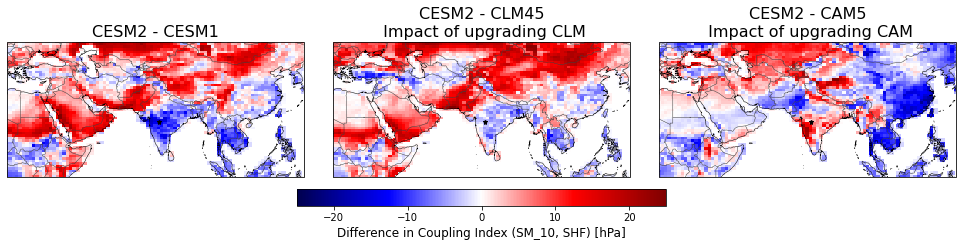

In [34]:
## Terrestrial leg 
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Zoom in on NH
axs[0].set_extent([20,130,0,50], crs=ccrs.PlateCarree())  
axs[1].set_extent([20,130,0,50], crs=ccrs.PlateCarree())  
axs[2].set_extent([20,130,0,50], crs=ccrs.PlateCarree())  

# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-25,vmax=25)

# Additional options 
axs[0].set_title('CESM2 - CESM1',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-25,vmax=25)

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SM_10, SHF) [hPa]',fontsize=12)

# Additional options 
axs[1].set_title('CESM2 - CLM45\n Impact of upgrading CLM',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
#   ...Diff_CESM2vCAM5  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCAM5,
                             cmap='seismic',
                             vmin=-25,vmax=25)

# Additional options 
axs[2].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# =========================================================
# --- Add star points
# ========================================================
# Lensk Russia (Not additive): 
ilat = np.where( (lat>=60.2) & (lat<=61.2))[0]
ilon = np.where( (lon>=114.5) & (lon<=115.5))[0]
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())

# CLM-driven: Santa Fe, NM 
ilat = np.where( (lat>=35.1) & (lat<=36.1))[0]
lonSel = (-105.9378 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())


# CAM-driven 
# Northern Alaska 
ilat = np.where( (lat>=68.5) & (lat<=69.5))[0]
lonSel = (-150.8514 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())

# Jalna India (also not additive):
ilat = np.where( (lat>=19.33) & (lat<=20.33))[0]
ilon = np.where( (lon>=75.3) & (lon<=76.3))[0]
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())




In [27]:
lat[np.where( (lat>=19.3) & (lat<=20.3))[0]]

array([19.31937173, 20.2617801 ])

In [35]:
# More detail
ilat = np.where( (lat>=19.33) & (lat<=20.33))[0]
ilon = np.where( (lon>=75.3) & (lon<=76.3))[0]
print('Point selected: lat = %.2f , lon = %.2f' % (lat[ilat], lon[ilon]))

cesm2 = TerraLeg_JJA_cyclic_cesm2[ilat,ilon]
cesm1 = TerraLeg_JJA_cyclic_cesm1[ilat,ilon]
clm45 = TerraLeg_JJA_cyclic_clm45[ilat,ilon]
cam5  = TerraLeg_JJA_cyclic_cam5[ilat,ilon]


print('CESM2: %.3f' % cesm2)
print('CESM1: %.3f' % cesm1)
print('CLM45: %.3f' % clm45)
print('CAM5:  %.3f' % cam5)
print()
print('Differences')
print('   CESM2-CESM1: %.3f' % (cesm2-cesm1))
print('   CESM2-CLM45: %.3f' % (cesm2-clm45))
print('   CESM2-CAM5:  %.3f' % (cesm2-cam5))
print()
# print('Ratio approach: %.3f' % ratio_terra[ilat,ilon])
# print()
print('Percent changes ')

pct_cesm1 = (cesm1-cesm2)/cesm2
pct_clm45 = (clm45-cesm2)/cesm2
pct_cam5  = (cam5-cesm2)/cesm2
pct_sum   = pct_clm45+pct_cam5
print('   CESM1: %.4f' % pct_cesm1 )
print('   CLM45: %.4f' % pct_clm45 )
print('   CAM5:  %.4f' % pct_cam5 )
print('   CLM45+CAM5: %.4f' % pct_sum)
print('   Residual:   %.4f' % (pct_sum - pct_cesm1) )



Point selected: lat = 20.26 , lon = 76.25
CESM2: -32.079
CESM1: -16.150
CLM45: -28.281
CAM5:  -41.708

Differences
   CESM2-CESM1: -15.929
   CESM2-CLM45: -3.798
   CESM2-CAM5:  9.629

Percent changes 
   CESM1: -0.4966
   CLM45: -0.1184
   CAM5:  0.3002
   CLM45+CAM5: 0.1818
   Residual:   0.6783


In [61]:
# # --- Set up custom colorbar --- 
# import matplotlib as mpl

# cmap = plt.cm.jet  # define the colormap
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(cmap.N)]


# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)

# # define the bins and normalize
# bounds = np.linspace(0, 4, 17)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)



In [149]:
# # Set up figure 
# fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
#                         facecolor='w', edgecolor='k',
#                         subplot_kw={'projection':ccrs.PlateCarree()})

# ax1.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 
# contour_plot = ax1.pcolormesh(lon_cyclic,lat,np.abs(ratio_terra),
#                               cmap = cmap, norm=norm)
# ax1.set_title('Terrestrial leg: | (dCLM+dCAM)/dCESM |', fontsize=14)

# # Add colorbar 
# ax_position = ax1.get_position()
# cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
# cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,  
#                            cmap = cmap, norm=norm, boundaries=bounds)
# cbar.set_label('| Ratio of dCLM+dCAM to dCESM |',fontsize=12)




In [148]:
# # Set up figure 
# fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
#                         facecolor='w', edgecolor='k',
#                         subplot_kw={'projection':ccrs.PlateCarree()})

# ax1.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 
# contour_plot = ax1.pcolormesh(lon_cyclic,lat,np.abs(ratio_atmo),
#                               cmap = cmap, norm=norm)
# ax1.set_title('Atmospheric leg: | (dCLM+dCAM)/dCESM |', fontsize=14)

# # Add colorbar 
# ax_position = ax1.get_position()
# cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
# cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,  
#                            cmap = cmap, norm=norm, boundaries=bounds)
# cbar.set_label('| Ratio of dCLM+dCAM to dCESM |',fontsize=12)


# ax1.plot(lon[100],lat[170],'r*',markersize=20,transform=ccrs.PlateCarree())


## Regional plots

In [33]:
# Create 3D mask of the regions mapped out above 
#   (better for actually getting averages and masking out other regions)
RegMask = regionmask.defined_regions.srex.mask_3D(lon, lat)


In [16]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask_notCyclic = np.full([len(lat),len(lon)],np.nan)
lndMask_notCyclic[np.where(np.isfinite(TerraLeg_JJA_cesm1))] = 1


In [90]:
# Compute mean and std of each experiment by region 
nRegion = len(RegMask.region)

atmoLeg_regionalMean_CESM2  = np.full([nRegion], np.nan)
atmoLeg_regionalMean_CESM1  = np.full([nRegion], np.nan)
atmoLeg_regionalMean_CLM45  = np.full([nRegion], np.nan)
atmoLeg_regionalMean_CAM5   = np.full([nRegion], np.nan)
terraLeg_regionalMean_CESM2 = np.full([nRegion], np.nan)
terraLeg_regionalMean_CESM1 = np.full([nRegion], np.nan)
terraLeg_regionalMean_CLM45 = np.full([nRegion], np.nan)
terraLeg_regionalMean_CAM5  = np.full([nRegion], np.nan)

atmoLeg_regionalStd_CESM2  = np.full([nRegion], np.nan)
atmoLeg_regionalStd_CESM1  = np.full([nRegion], np.nan)
atmoLeg_regionalStd_CLM45  = np.full([nRegion], np.nan)
atmoLeg_regionalStd_CAM5   = np.full([nRegion], np.nan)
terraLeg_regionalStd_CESM2 = np.full([nRegion], np.nan)
terraLeg_regionalStd_CESM1 = np.full([nRegion], np.nan)
terraLeg_regionalStd_CLM45 = np.full([nRegion], np.nan)
terraLeg_regionalStd_CAM5  = np.full([nRegion], np.nan)


for iReg in range(nRegion):
    # First, isolate region
    rSel = RegMask.sel(region=iReg+1)
    
    # Select region in arrays 
    atmoLeg_cesm2_reg = (AtmoLeg_JJA_cesm2*lndMask_notCyclic)[rSel==True]
    atmoLeg_cesm1_reg = (AtmoLeg_JJA_cesm1*lndMask_notCyclic)[rSel==True]
    atmoLeg_clm45_reg = (AtmoLeg_JJA_clm45*lndMask_notCyclic)[rSel==True]
    atmoLeg_cam5_reg  = (AtmoLeg_JJA_cam5*lndMask_notCyclic)[rSel==True]
    
    terraLeg_cesm2_reg = TerraLeg_JJA_cesm2[rSel==True]
    terraLeg_cesm1_reg = TerraLeg_JJA_cesm1[rSel==True]
    terraLeg_clm45_reg = TerraLeg_JJA_clm45[rSel==True]
    terraLeg_cam5_reg  = TerraLeg_JJA_cam5[rSel==True]
    
    # Save mean and std into arrays 
    atmoLeg_regionalMean_CESM2[iReg] = np.nanmean(atmoLeg_cesm2_reg)
    atmoLeg_regionalMean_CESM1[iReg] = np.nanmean(atmoLeg_cesm1_reg)
    atmoLeg_regionalMean_CLM45[iReg] = np.nanmean(atmoLeg_clm45_reg)
    atmoLeg_regionalMean_CAM5[iReg]  = np.nanmean(atmoLeg_cam5_reg)

    terraLeg_regionalMean_CESM2[iReg] = np.nanmean(terraLeg_cesm2_reg)
    terraLeg_regionalMean_CESM1[iReg] = np.nanmean(terraLeg_cesm1_reg)
    terraLeg_regionalMean_CLM45[iReg] = np.nanmean(terraLeg_clm45_reg)
    terraLeg_regionalMean_CAM5[iReg]  = np.nanmean(terraLeg_cam5_reg)
    
    atmoLeg_regionalStd_CESM2[iReg]   = np.nanstd(atmoLeg_cesm2_reg)
    atmoLeg_regionalStd_CESM1[iReg]   = np.nanstd(atmoLeg_cesm1_reg)
    atmoLeg_regionalStd_CLM45[iReg]   = np.nanstd(atmoLeg_clm45_reg)
    atmoLeg_regionalStd_CAM5[iReg]    = np.nanstd(atmoLeg_cam5_reg)

    terraLeg_regionalStd_CESM2[iReg]  = np.nanstd(terraLeg_cesm2_reg)
    terraLeg_regionalStd_CESM1[iReg]  = np.nanstd(terraLeg_cesm1_reg)
    terraLeg_regionalStd_CLM45[iReg]  = np.nanstd(terraLeg_clm45_reg)
    terraLeg_regionalStd_CAM5[iReg]   = np.nanstd(terraLeg_cam5_reg)



**Now figure out how to plot this - have fun!**

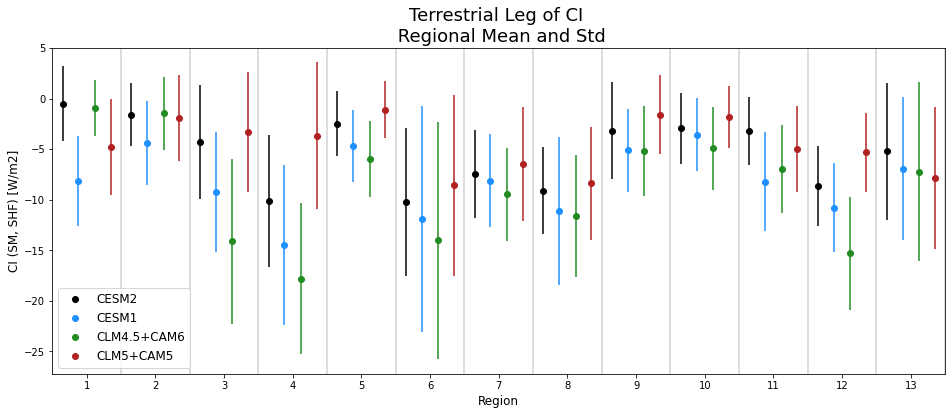

In [130]:
# Set array of regions 
indRegions = np.linspace(1,nRegion,nRegion)
regName    = RegMask.names.values


# Set up figure for TERRESTRIAL LEG of CI (SM, SHF)
fig, ax1 = plt.subplots(1,1, figsize=(16, 6))

for iReg in range(int(nRegion/2)):
    # Plot dot to mark the mean
    ax1.plot(indRegions[iReg]-0.35, terraLeg_regionalMean_CESM2[iReg],'o', color='k')
    ax1.plot(indRegions[iReg]-0.12, terraLeg_regionalMean_CESM1[iReg],'o', color='dodgerblue')
    ax1.plot(indRegions[iReg]+0.12, terraLeg_regionalMean_CLM45[iReg],'o', color='forestgreen')
    ax1.plot(indRegions[iReg]+0.35, terraLeg_regionalMean_CAM5[iReg], 'o',  color='firebrick')
    
    
    # Plot error bars corresponding to +/- 1 std of region 
    ax1.errorbar(indRegions[iReg]-0.35, terraLeg_regionalMean_CESM2[iReg],   # Plot CESM2
                  terraLeg_regionalStd_CESM2[iReg], ecolor='k')
    ax1.errorbar(indRegions[iReg]-0.12, terraLeg_regionalMean_CESM1[iReg],   # Plot CESM1
                  terraLeg_regionalStd_CESM1[iReg], ecolor='dodgerblue')
    ax1.errorbar(indRegions[iReg]+0.12, terraLeg_regionalMean_CLM45[iReg],   # Plot CLM4.5
                  terraLeg_regionalStd_CLM45[iReg], ecolor='forestgreen')
    ax1.errorbar(indRegions[iReg]+0.35, terraLeg_regionalMean_CAM5[iReg],    # Plot CAM5 
                  terraLeg_regionalStd_CAM5[iReg], ecolor='firebrick')
    
    # Seperate out regions with light gray lines
    ax1.axvline(indRegions[iReg]+0.5, color='lightgrey')


ax1.set_title('Terrestrial Leg of CI \n Regional Mean and Std',fontsize=18)
ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'], fontsize=12, loc='lower left')
ax1.set_ylabel('CI (SM, SHF) [W/m2]', fontsize=12)
ax1.set_xlim([0.5,(nRegion/2)+0.5])
ax1.set_xlabel('Region',fontsize=12)
ax1.set_xticks(indRegions[0:int(nRegion/2)])
# ax1.set_xticklabels(regName[0:int(nRegion/2)+1])
                 
plt.show()


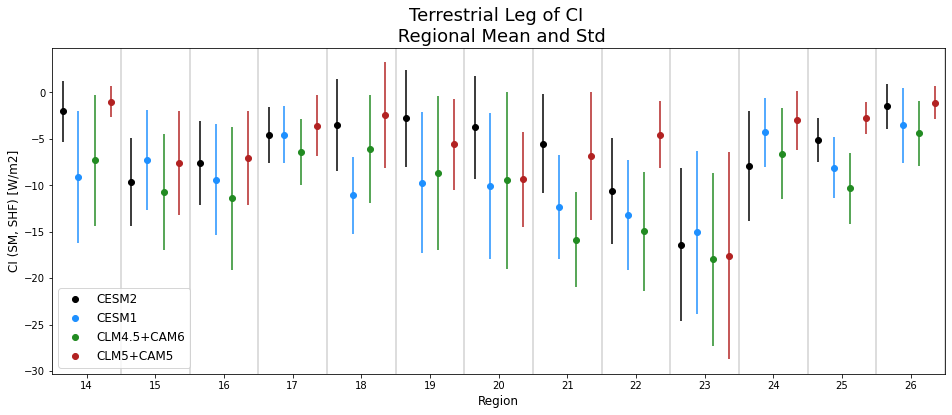

In [132]:
# Set array of regions 
indRegions = np.linspace(1,nRegion,nRegion)
regName    = RegMask.names.values
offset     = int(nRegion/2)   # Offset to look at next half of regions 

# Set up figure for TERRESTRIAL LEG of CI (SM, SHF)
fig, ax1 = plt.subplots(1,1, figsize=(16, 6))

for iReg in range(int(nRegion/2)):
    # Plot dot to mark the mean
    ax1.plot(indRegions[iReg+offset]-0.35, terraLeg_regionalMean_CESM2[iReg+offset],'o', color='k')
    ax1.plot(indRegions[iReg+offset]-0.12, terraLeg_regionalMean_CESM1[iReg+offset],'o', color='dodgerblue')
    ax1.plot(indRegions[iReg+offset]+0.12, terraLeg_regionalMean_CLM45[iReg+offset],'o', color='forestgreen')
    ax1.plot(indRegions[iReg+offset]+0.35, terraLeg_regionalMean_CAM5[iReg+offset], 'o',  color='firebrick')
    
    
    # Plot error bars corresponding to +/- 1 std of region 
    ax1.errorbar(indRegions[iReg+offset]-0.35, terraLeg_regionalMean_CESM2[iReg+offset],   # Plot CESM2
                  terraLeg_regionalStd_CESM2[iReg+offset], ecolor='k')
    ax1.errorbar(indRegions[iReg+offset]-0.12, terraLeg_regionalMean_CESM1[iReg+offset],   # Plot CESM1
                  terraLeg_regionalStd_CESM1[iReg+offset], ecolor='dodgerblue')
    ax1.errorbar(indRegions[iReg+offset]+0.12, terraLeg_regionalMean_CLM45[iReg+offset],   # Plot CLM4.5
                  terraLeg_regionalStd_CLM45[iReg+offset], ecolor='forestgreen')
    ax1.errorbar(indRegions[iReg+offset]+0.35, terraLeg_regionalMean_CAM5[iReg+offset],    # Plot CAM5 
                  terraLeg_regionalStd_CAM5[iReg+offset], ecolor='firebrick')
    
    # Seperate out regions with light gray lines
    ax1.axvline(indRegions[iReg+offset]+0.5, color='lightgrey')


ax1.set_title('Terrestrial Leg of CI \n Regional Mean and Std',fontsize=18)
ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'], fontsize=12, loc='lower left')
ax1.set_ylabel('CI (SM, SHF) [W/m2]', fontsize=12)
ax1.set_xlim([0.5+offset,(nRegion)+0.5])
ax1.set_xlabel('Region',fontsize=12)
ax1.set_xticks(indRegions[offset::])
# ax1.set_xticklabels(regName[offset::])
                 
plt.show()



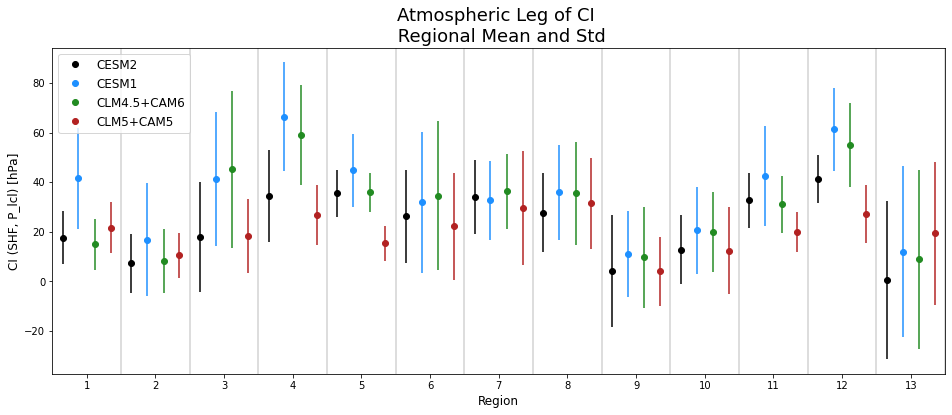

In [141]:
# Set array of regions 
indRegions = np.linspace(1,nRegion,nRegion)
regName    = RegMask.names.values


# Set up figure for ATMOSPHERIC LEG of CI (SM, SHF)
fig, ax1 = plt.subplots(1,1, figsize=(16, 6))

for iReg in range(int(nRegion/2)):
    # Plot dot to mark the mean
    ax1.plot(indRegions[iReg]-0.35, atmoLeg_regionalMean_CESM2[iReg],'o', color='k')
    ax1.plot(indRegions[iReg]-0.12, atmoLeg_regionalMean_CESM1[iReg],'o', color='dodgerblue')
    ax1.plot(indRegions[iReg]+0.12, atmoLeg_regionalMean_CLM45[iReg],'o', color='forestgreen')
    ax1.plot(indRegions[iReg]+0.35, atmoLeg_regionalMean_CAM5[iReg], 'o',  color='firebrick')
    
    
    # Plot error bars corresponding to +/- 1 std of region 
    ax1.errorbar(indRegions[iReg]-0.35, atmoLeg_regionalMean_CESM2[iReg],   # Plot CESM2
                  atmoLeg_regionalStd_CESM2[iReg], ecolor='k')
    ax1.errorbar(indRegions[iReg]-0.12, atmoLeg_regionalMean_CESM1[iReg],   # Plot CESM1
                  atmoLeg_regionalStd_CESM1[iReg], ecolor='dodgerblue')
    ax1.errorbar(indRegions[iReg]+0.12, atmoLeg_regionalMean_CLM45[iReg],   # Plot CLM4.5
                  atmoLeg_regionalStd_CLM45[iReg], ecolor='forestgreen')
    ax1.errorbar(indRegions[iReg]+0.35, atmoLeg_regionalMean_CAM5[iReg],    # Plot CAM5 
                 atmoLeg_regionalStd_CAM5[iReg], ecolor='firebrick')
    
    # Seperate out regions with light gray lines
    ax1.axvline(indRegions[iReg]+0.5, color='lightgrey')


ax1.set_title('Atmospheric Leg of CI \n Regional Mean and Std',fontsize=18)
ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'], fontsize=12, loc='upper left')
ax1.set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=12)
ax1.set_xlim([0.5,(nRegion/2)+0.5])
ax1.set_xlabel('Region',fontsize=12)
ax1.set_xticks(indRegions[0:int(nRegion/2)])
# ax1.set_xticklabels(regName[0:int(nRegion/2)+1])
                 
plt.show()



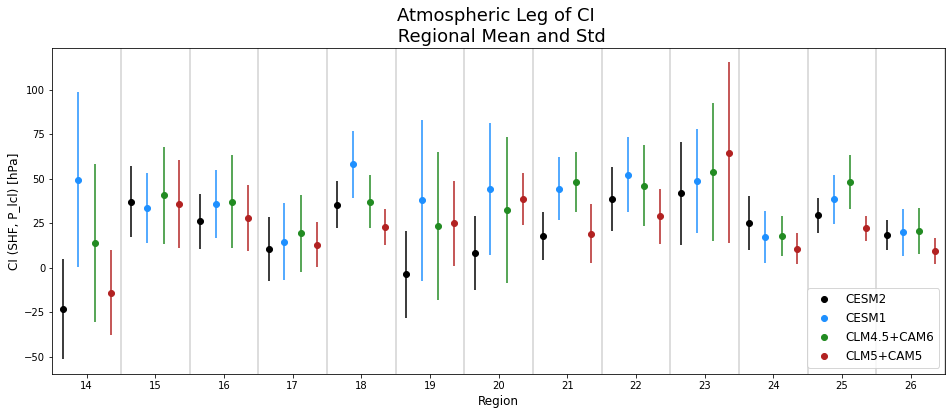

In [138]:
# Set array of regions 
indRegions = np.linspace(1,nRegion,nRegion)
regName    = RegMask.names.values
offset     = int(nRegion/2)   # Offset to look at next half of regions 

# Set up figure for ATMOSPHERIC LEG of CI (SM, SHF)
fig, ax1 = plt.subplots(1,1, figsize=(16, 6))

for iReg in range(int(nRegion/2)):
    # Plot dot to mark the mean
    ax1.plot(indRegions[iReg+offset]-0.35, atmoLeg_regionalMean_CESM2[iReg+offset],'o', color='k')
    ax1.plot(indRegions[iReg+offset]-0.12, atmoLeg_regionalMean_CESM1[iReg+offset],'o', color='dodgerblue')
    ax1.plot(indRegions[iReg+offset]+0.12, atmoLeg_regionalMean_CLM45[iReg+offset],'o', color='forestgreen')
    ax1.plot(indRegions[iReg+offset]+0.35, atmoLeg_regionalMean_CAM5[iReg+offset], 'o',  color='firebrick')
    
    
    # Plot error bars corresponding to +/- 1 std of region 
    ax1.errorbar(indRegions[iReg+offset]-0.35, atmoLeg_regionalMean_CESM2[iReg+offset],   # Plot CESM2
                  atmoLeg_regionalStd_CESM2[iReg+offset], ecolor='k')
    ax1.errorbar(indRegions[iReg+offset]-0.12, atmoLeg_regionalMean_CESM1[iReg+offset],   # Plot CESM1
                  atmoLeg_regionalStd_CESM1[iReg+offset], ecolor='dodgerblue')
    ax1.errorbar(indRegions[iReg+offset]+0.12, atmoLeg_regionalMean_CLM45[iReg+offset],   # Plot CLM4.5
                  atmoLeg_regionalStd_CLM45[iReg+offset], ecolor='forestgreen')
    ax1.errorbar(indRegions[iReg+offset]+0.35, atmoLeg_regionalMean_CAM5[iReg+offset],    # Plot CAM5 
                  atmoLeg_regionalStd_CAM5[iReg+offset], ecolor='firebrick')
    
    # Seperate out regions with light gray lines
    ax1.axvline(indRegions[iReg+offset]+0.5, color='lightgrey')


ax1.set_title('Atmospheric Leg of CI \n Regional Mean and Std',fontsize=18)
ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'], fontsize=12, loc='lower right')
ax1.set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=12)
ax1.set_xlim([0.5+offset,(nRegion)+0.5])
ax1.set_xlabel('Region',fontsize=12)
ax1.set_xticks(indRegions[offset::])
# ax1.set_xticklabels(regName[offset::])
                 
plt.show()




**Zonal means?**

<ipython-input-17-db6cecb13546>:3: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
<ipython-input-17-db6cecb13546>:4: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_JJA_cesm1*lndMask_notCyclic,axis=1)
<ipython-input-17-db6cecb13546>:5: RuntimeWarning: Mean of empty slice
  lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)


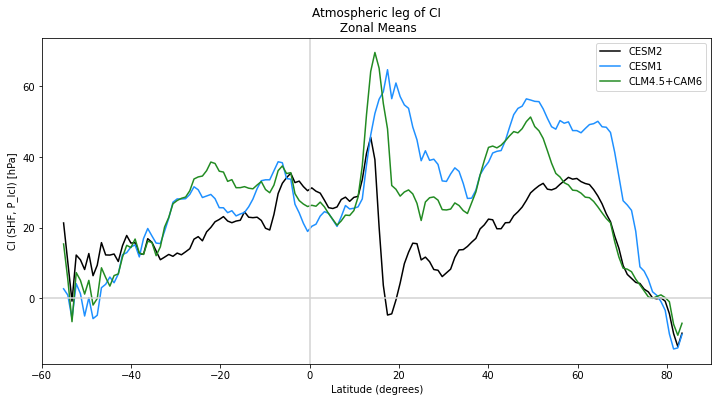

In [17]:
# Atmospheric leg of CI 

lonMean_atmoLeg_CESM2 = np.nanmean(AtmoLeg_JJA_cesm2*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CESM1 = np.nanmean(AtmoLeg_JJA_cesm1*lndMask_notCyclic,axis=1)
lonMean_atmoLeg_CLM45 = np.nanmean(AtmoLeg_JJA_clm45*lndMask_notCyclic,axis=1)
#lonMean_atmoLeg_CAM5  = np.nanmean(AtmoLeg_JJA_cam5*lndMask_notCyclic, axis=1)

# Now plot that 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,lonMean_atmoLeg_CESM2,'k')
ax1.plot(lat,lonMean_atmoLeg_CESM1,'dodgerblue')
ax1.plot(lat,lonMean_atmoLeg_CLM45,'forestgreen')
#ax1.plot(lat,lonMean_atmoLeg_CAM5,'firebrick')

#ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'])
ax1.legend(['CESM2','CESM1','CLM4.5+CAM6'])
ax1.set_xlabel('Latitude (degrees)')
ax1.set_ylabel('CI (SHF, P_lcl) [hPa]')
ax1.set_title('Atmospheric leg of CI\n Zonal Means')
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')


<ipython-input-18-0ff1bc6d7f47>:3: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_JJA_cesm2, axis=1)
<ipython-input-18-0ff1bc6d7f47>:4: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CESM1 = np.nanmean(TerraLeg_JJA_cesm1, axis=1)
<ipython-input-18-0ff1bc6d7f47>:5: RuntimeWarning: Mean of empty slice
  lonMean_terraLeg_CLM45 = np.nanmean(TerraLeg_JJA_clm45, axis=1)


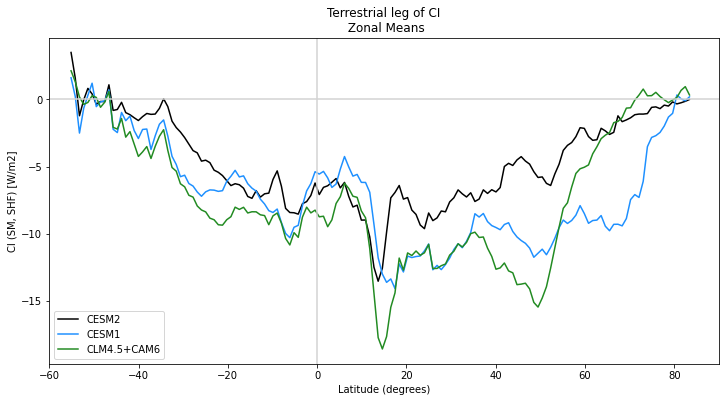

In [18]:
# Atmospheric leg of CI 

lonMean_terraLeg_CESM2 = np.nanmean(TerraLeg_JJA_cesm2, axis=1)
lonMean_terraLeg_CESM1 = np.nanmean(TerraLeg_JJA_cesm1, axis=1)
lonMean_terraLeg_CLM45 = np.nanmean(TerraLeg_JJA_clm45, axis=1)
#lonMean_terraLeg_CAM5  = np.nanmean(TerraLeg_JJA_cam5,  axis=1)

# Now plot that 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,lonMean_terraLeg_CESM2,'k')
ax1.plot(lat,lonMean_terraLeg_CESM1,'dodgerblue')
ax1.plot(lat,lonMean_terraLeg_CLM45,'forestgreen')
#ax1.plot(lat,lonMean_terraLeg_CAM5,'firebrick')

#ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'])
ax1.legend(['CESM2','CESM1','CLM4.5+CAM6'])
ax1.set_xlabel('Latitude (degrees)')
ax1.set_ylabel('CI (SM, SHF) [W/m2]')
ax1.set_title('Terrestrial leg of CI\n Zonal Means')
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')


## Other seasons?

In [8]:
atmoLeg_CESM1

<xarray.Dataset>
Dimensions:        (lat: 192, lon: 288, season: 4)
Coordinates:
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    SHFLX_Plcl_CI  (season, lat, lon) float64 ...

In [11]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
AtmoLeg_DJF_cesm1  = np.squeeze(np.asarray(atmoLeg_CESM1.SHFLX_Plcl_CI[0,:,:]))
TerraLeg_DJF_cesm1 = np.squeeze(np.asarray(terraLeg_CESM1.soilM_10_SHFLX_CI[0,:,:]))
AtmoLeg_DJF_cesm2  = np.squeeze(np.asarray(atmoLeg_CESM2.hfss_Plcl_CI[0,:,:]))
TerraLeg_DJF_cesm2 = np.squeeze(np.asarray(terraLeg_CESM2.mrsos_hfss_CI[0,:,:]))
AtmoLeg_DJF_clm45  = np.squeeze(np.asarray(atmoLeg_CLM45.SHFLX_Plcl_CI[0,:,:]))
TerraLeg_DJF_clm45 = np.squeeze(np.asarray(terraLeg_CLM45.soilM_10_SHFLX_CI[0,:,:]))
AtmoLeg_DJF_cam5  = np.squeeze(np.asarray(atmoLeg_CAM5.SHFLX_Plcl_CI[0,:,:]))
TerraLeg_DJF_cam5 = np.squeeze(np.asarray(terraLeg_CAM5.soilM_10_SHFLX_CI[0,:,:]))

# Make cyclic first 
AtmoLeg_DJF_cyclic_cesm1, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_DJF_cesm1, lon)
TerraLeg_DJF_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_DJF_cesm1, lon)
AtmoLeg_DJF_cyclic_cesm2, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_DJF_cesm2, lon)
TerraLeg_DJF_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_DJF_cesm2, lon)
AtmoLeg_DJF_cyclic_clm45, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_DJF_clm45, lon)
TerraLeg_DJF_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_DJF_clm45, lon)
AtmoLeg_DJF_cyclic_cam5, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_DJF_cam5, lon)
TerraLeg_DJF_cyclic_cam5, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_DJF_cam5, lon)


# Now get color coded arrays 
colorsAtmoLeg_cesm1  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cesm2  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_clm45  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cam5   = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cam5  = np.full([len(lat),len(lon)+1],np.nan)

# ----- CESM 1 ------

# Atmo leg 
colorsAtmoLeg_cesm1[np.where(AtmoLeg_DJF_cyclic_cesm1<-150)]                                 = 1
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>-150) & (AtmoLeg_DJF_cyclic_cesm1<=-100))]  = 2
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>-100) & (AtmoLeg_DJF_cyclic_cesm1<=-50))]   = 3
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>-50)  & (AtmoLeg_DJF_cyclic_cesm1<=-20))]   = 4
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>-20)  & (AtmoLeg_DJF_cyclic_cesm1<=0))]     = 5
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>0)    & (AtmoLeg_DJF_cyclic_cesm1<=20))]    = 6
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>20)   & (AtmoLeg_DJF_cyclic_cesm1<=40))]    = 7
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>40)   & (AtmoLeg_DJF_cyclic_cesm1<=60))]    = 8
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>60)   & (AtmoLeg_DJF_cyclic_cesm1<=80))]    = 9
colorsAtmoLeg_cesm1[np.where((AtmoLeg_DJF_cyclic_cesm1>80)   & (AtmoLeg_DJF_cyclic_cesm1<=100))]   = 10
colorsAtmoLeg_cesm1[np.where(AtmoLeg_DJF_cyclic_cesm1>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm1[np.where(TerraLeg_DJF_cyclic_cesm1<-20)]                                 = 1
colorsTerraLeg_cesm1[np.where((TerraLeg_DJF_cyclic_cesm1>-20) & (TerraLeg_DJF_cyclic_cesm1<=-15))]  = 2
colorsTerraLeg_cesm1[np.where((TerraLeg_DJF_cyclic_cesm1>-15) & (TerraLeg_DJF_cyclic_cesm1<=-10))]  = 3
colorsTerraLeg_cesm1[np.where((TerraLeg_DJF_cyclic_cesm1>-10) & (TerraLeg_DJF_cyclic_cesm1<=-5))]   = 4
colorsTerraLeg_cesm1[np.where((TerraLeg_DJF_cyclic_cesm1>-5)  & (TerraLeg_DJF_cyclic_cesm1<=-2))]    = 5
colorsTerraLeg_cesm1[np.where((TerraLeg_DJF_cyclic_cesm1>-2)  & (TerraLeg_DJF_cyclic_cesm1<=-1))]    = 6
colorsTerraLeg_cesm1[np.where((TerraLeg_DJF_cyclic_cesm1>-1)  & (TerraLeg_DJF_cyclic_cesm1<=0))]     = 7
colorsTerraLeg_cesm1[np.where(TerraLeg_DJF_cyclic_cesm1>0)]                                   = 8


# ----- CESM 2 ------

# Atmo leg 
colorsAtmoLeg_cesm2[np.where(AtmoLeg_DJF_cyclic_cesm2<-150)]                                 = 1
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>-150) & (AtmoLeg_DJF_cyclic_cesm2<=-100))]  = 2
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>-100) & (AtmoLeg_DJF_cyclic_cesm2<=-50))]   = 3
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>-50)  & (AtmoLeg_DJF_cyclic_cesm2<=-20))]   = 4
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>-20)  & (AtmoLeg_DJF_cyclic_cesm2<=0))]     = 5
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>0)    & (AtmoLeg_DJF_cyclic_cesm2<=20))]    = 6
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>20)   & (AtmoLeg_DJF_cyclic_cesm2<=40))]    = 7
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>40)   & (AtmoLeg_DJF_cyclic_cesm2<=60))]    = 8
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>60)   & (AtmoLeg_DJF_cyclic_cesm2<=80))]    = 9
colorsAtmoLeg_cesm2[np.where((AtmoLeg_DJF_cyclic_cesm2>80)   & (AtmoLeg_DJF_cyclic_cesm2<=100))]   = 10
colorsAtmoLeg_cesm2[np.where(AtmoLeg_DJF_cyclic_cesm2>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm2[np.where(TerraLeg_DJF_cyclic_cesm2<-20)]                                 = 1
colorsTerraLeg_cesm2[np.where((TerraLeg_DJF_cyclic_cesm2>-20) & (TerraLeg_DJF_cyclic_cesm2<=-15))]  = 2
colorsTerraLeg_cesm2[np.where((TerraLeg_DJF_cyclic_cesm2>-15) & (TerraLeg_DJF_cyclic_cesm2<=-10))]  = 3
colorsTerraLeg_cesm2[np.where((TerraLeg_DJF_cyclic_cesm2>-10) & (TerraLeg_DJF_cyclic_cesm2<=-5))]   = 4
colorsTerraLeg_cesm2[np.where((TerraLeg_DJF_cyclic_cesm2>-5)  & (TerraLeg_DJF_cyclic_cesm2<=-2))]    = 5
colorsTerraLeg_cesm2[np.where((TerraLeg_DJF_cyclic_cesm2>-2)  & (TerraLeg_DJF_cyclic_cesm2<=-1))]    = 6
colorsTerraLeg_cesm2[np.where((TerraLeg_DJF_cyclic_cesm2>-1)  & (TerraLeg_DJF_cyclic_cesm2<=0))]     = 7
colorsTerraLeg_cesm2[np.where(TerraLeg_DJF_cyclic_cesm2>0)]                                   = 8



# ----- CLM4.5 ------

# Atmo leg 
colorsAtmoLeg_clm45[np.where(AtmoLeg_DJF_cyclic_clm45<-150)]                                 = 1
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>-150) & (AtmoLeg_DJF_cyclic_clm45<=-100))]  = 2
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>-100) & (AtmoLeg_DJF_cyclic_clm45<=-50))]   = 3
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>-50)  & (AtmoLeg_DJF_cyclic_clm45<=-20))]   = 4
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>-20)  & (AtmoLeg_DJF_cyclic_clm45<=0))]     = 5
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>0)    & (AtmoLeg_DJF_cyclic_clm45<=20))]    = 6
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>20)   & (AtmoLeg_DJF_cyclic_clm45<=40))]    = 7
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>40)   & (AtmoLeg_DJF_cyclic_clm45<=60))]    = 8
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>60)   & (AtmoLeg_DJF_cyclic_clm45<=80))]    = 9
colorsAtmoLeg_clm45[np.where((AtmoLeg_DJF_cyclic_clm45>80)   & (AtmoLeg_DJF_cyclic_clm45<=100))]   = 10
colorsAtmoLeg_clm45[np.where(AtmoLeg_DJF_cyclic_clm45>100)]                                  = 11


# Terra leg  
colorsTerraLeg_clm45[np.where(TerraLeg_DJF_cyclic_clm45<-20)]                                 = 1
colorsTerraLeg_clm45[np.where((TerraLeg_DJF_cyclic_clm45>-20) & (TerraLeg_DJF_cyclic_clm45<=-15))]  = 2
colorsTerraLeg_clm45[np.where((TerraLeg_DJF_cyclic_clm45>-15) & (TerraLeg_DJF_cyclic_clm45<=-10))]  = 3
colorsTerraLeg_clm45[np.where((TerraLeg_DJF_cyclic_clm45>-10) & (TerraLeg_DJF_cyclic_clm45<=-5))]   = 4
colorsTerraLeg_clm45[np.where((TerraLeg_DJF_cyclic_clm45>-5)  & (TerraLeg_DJF_cyclic_clm45<=-2))]    = 5
colorsTerraLeg_clm45[np.where((TerraLeg_DJF_cyclic_clm45>-2)  & (TerraLeg_DJF_cyclic_clm45<=-1))]    = 6
colorsTerraLeg_clm45[np.where((TerraLeg_DJF_cyclic_clm45>-1)  & (TerraLeg_DJF_cyclic_clm45<=0))]     = 7
colorsTerraLeg_clm45[np.where(TerraLeg_DJF_cyclic_clm45>0)]                                   = 8



# ----- CAM5 ------

# Atmo leg 
colorsAtmoLeg_cam5[np.where(AtmoLeg_DJF_cyclic_cam5<-150)]                                 = 1
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>-150) & (AtmoLeg_DJF_cyclic_cam5<=-100))]  = 2
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>-100) & (AtmoLeg_DJF_cyclic_cam5<=-50))]   = 3
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>-50)  & (AtmoLeg_DJF_cyclic_cam5<=-20))]   = 4
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>-20)  & (AtmoLeg_DJF_cyclic_cam5<=0))]     = 5
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>0)    & (AtmoLeg_DJF_cyclic_cam5<=20))]    = 6
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>20)   & (AtmoLeg_DJF_cyclic_cam5<=40))]    = 7
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>40)   & (AtmoLeg_DJF_cyclic_cam5<=60))]    = 8
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>60)   & (AtmoLeg_DJF_cyclic_cam5<=80))]    = 9
colorsAtmoLeg_cam5[np.where((AtmoLeg_DJF_cyclic_cam5>80)   & (AtmoLeg_DJF_cyclic_cam5<=100))]   = 10
colorsAtmoLeg_cam5[np.where(AtmoLeg_DJF_cyclic_cam5>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cam5[np.where(TerraLeg_DJF_cyclic_cam5<-20)]                                 = 1
colorsTerraLeg_cam5[np.where((TerraLeg_DJF_cyclic_cam5>-20) & (TerraLeg_DJF_cyclic_cam5<=-15))]  = 2
colorsTerraLeg_cam5[np.where((TerraLeg_DJF_cyclic_cam5>-15) & (TerraLeg_DJF_cyclic_cam5<=-10))]  = 3
colorsTerraLeg_cam5[np.where((TerraLeg_DJF_cyclic_cam5>-10) & (TerraLeg_DJF_cyclic_cam5<=-5))]   = 4
colorsTerraLeg_cam5[np.where((TerraLeg_DJF_cyclic_cam5>-5)  & (TerraLeg_DJF_cyclic_cam5<=-2))]    = 5
colorsTerraLeg_cam5[np.where((TerraLeg_DJF_cyclic_cam5>-2)  & (TerraLeg_DJF_cyclic_cam5<=-1))]    = 6
colorsTerraLeg_cam5[np.where((TerraLeg_DJF_cyclic_cam5>-1)  & (TerraLeg_DJF_cyclic_cam5<=0))]     = 7
colorsTerraLeg_cam5[np.where(TerraLeg_DJF_cyclic_cam5>0)]                                   = 8



In [12]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask = np.full([len(lat),len(lon)+1],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_DJF_cyclic_cesm1))] = 1


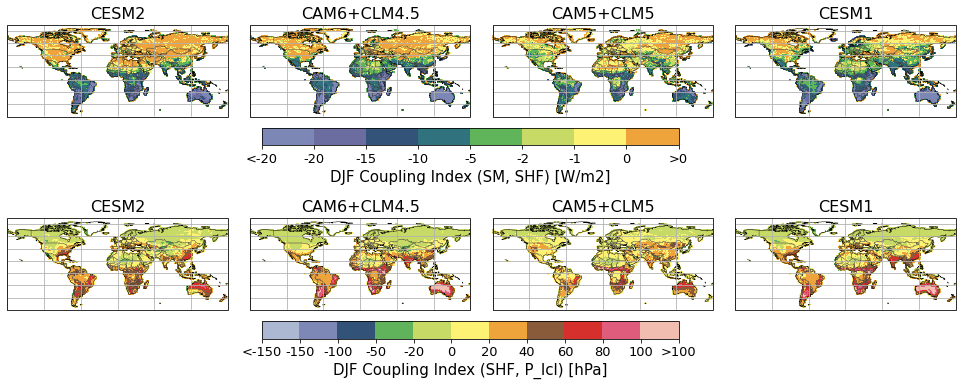

In [13]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsTerraLeg_clm45,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('DJF Coupling Index (SM, SHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=13)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_clm45*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('DJF Coupling Index (SHF, P_lcl) [hPa]',fontsize=15)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=13)  # vertically oriented colorbar


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[5].set_title('CAM6+CLM4.5',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cam5,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[6].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cam5*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[6].set_title('CAM5+CLM5',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm1,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm1*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[7].set_title('CESM1',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



### Can we plot difference? 

In [14]:
atmoDiff_CESM2vCESM1 = AtmoLeg_DJF_cyclic_cesm2 - AtmoLeg_DJF_cyclic_cesm1  # Impact of upgrading CAM and CLM 
atmoDiff_CESM2vCLM45 = AtmoLeg_DJF_cyclic_cesm2 - AtmoLeg_DJF_cyclic_clm45  # Impact of upgrading CAM 
atmoDiff_CESM2vCAM5  = AtmoLeg_DJF_cyclic_cesm2 - AtmoLeg_DJF_cyclic_cam5   # Impact of upgrading CLM 

terraDiff_CESM2vCESM1 = TerraLeg_DJF_cyclic_cesm2 - TerraLeg_DJF_cyclic_cesm1 # Impact of upgrading CAM and CLM  
terraDiff_CESM2vCLM45 = TerraLeg_DJF_cyclic_cesm2 - TerraLeg_DJF_cyclic_clm45 # Impact of upgrading CAM 
terraDiff_CESM2vCAM5  = TerraLeg_DJF_cyclic_cesm2 - TerraLeg_DJF_cyclic_cam5  # Impact of upgrading CLM 


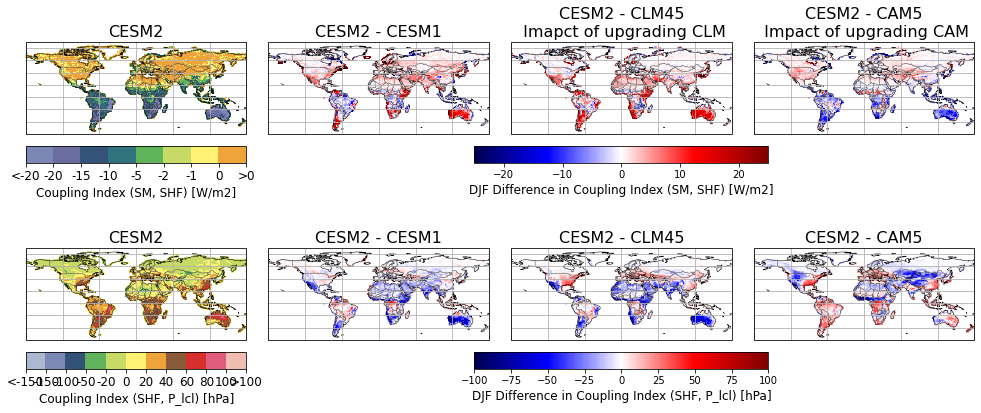

In [15]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=12)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=12)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=12)  # vertically oriented colorbar


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-25,vmax=25)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-25,vmax=25)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF Difference in Coupling Index (SM, SHF) [W/m2]',fontsize=12)


contour_plot = axs[6].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Add colorbar 
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
#   ...Diff_CESM2vCAM5
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCAM5,
                             cmap='seismic',
                             vmin=-25,vmax=25)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCAM5*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[7].set_title('CESM2 - CAM5',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



## Dig into underlying variables

### Read in data 
Note that this is all loaded/mapped on Casper

In [4]:
# Set up directories to read in data from... 
mainDir  = '/glade/work/mdfowler/data/'

dirCESM1 = mainDir+'CESM1/'
dirCESM2 = mainDir+'CESM2/'
dirCLM45 = mainDir+'CESM2_clm4.5/'
dirCAM5  = mainDir+'CESM2_cam5/'


In [4]:
# ----- Read in CESM2 soil moisture, sensible heat flux, Plcl ------- 

middleName    = '_day_CESM2_amip_r10i1p1f1_gn_'
timeName_flx  = ['19700101-19791231','19800101-19891231', 
                 '19900101-19991231','20000101-20091231']
timeName_soil = ['19500101-19991231','20000101-20150101']


# Read in surface fluxes
for iT in range(len(timeName_flx)):

    # --- Compile surface fluxes into singe large arrays in time 

    # Sensible heat flux
    shFile       = dirCESM2+'hfss'+middleName+timeName_flx[iT]+'.nc' # File name
    shDF         = xr.open_dataset(shFile,decode_times=True)
    shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    if iT==0:
        shflx_full = shDF
    else: 
        shflx_full = xr.concat([shflx_full, shDF], dim="time")

    print('Done with ', timeName_flx[iT])


for iT in range(len(timeName_soil)):

    # --- Compile soil moisture into singe large arrays in time     
    # 10 cm SM 
    soil10File = dirCESM2+'mrsos'+middleName+timeName_soil[iT]+'.nc' # File name
    soil10DF   = xr.open_dataset(soil10File,decode_times=True)
    soil10DF['time'] = soil10DF.indexes['time'].to_datetimeindex()
    
    if iT==0:
        soilM10_full = soil10DF
    else: 
        soilM10_full = xr.concat([soilM10_full, soil10DF], dim="time")

    print('Done with ', timeName_soil[iT])
    
# Load pressure level of LCL (computed separately in Get_LCLpressure.py and saved as pickle file)
lclPath = '/glade/work/mdfowler/data/CESM2/LCL-pressure-HeightAboveGround_1970-2014.p'
Plcl    = pickle.load( open( lclPath, "rb" ) )

# ---- Limit time period to be 1979-2006 ---- # 
# Limit time period of soil moisture: 
dates       = pd.DatetimeIndex(soilM10_full['time'].values)
iIncludeSM  = np.where((dates.year>=1979) & (dates.year<=2006))[0]
soilM10_CESM2 = np.asarray(soilM10_full.mrsos.values)[iIncludeSM,:,:]

# Now limit the time period of everything else 
dates     = pd.DatetimeIndex(shflx_full['time'].values)
iInclude  = np.where((dates.year>=1979) & (dates.year<=2006))[0]
dates     = dates[iInclude]

SHflx_CESM2 = np.asarray(shflx_full.hfss.values)[iInclude,:,:]
Plcl_CESM2  = Plcl[iInclude,:,:]
    
print('Done with reading in CESM2 data')

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Done with  19700101-19791231
Done with  19800101-19891231
Done with  19900101-19991231
Done with  20000101-20091231


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Done with  19500101-19991231
Done with  20000101-20150101
Done with reading in CESM2 data


In [5]:
# Delete things we won't use again 
del soilM10_full
del Plcl


In [ ]:
# ----- Read in CESM1 soil moisture, sensible heat flux, Plcl ------- 

startCLM = 'cam5.1_amip_1d_002.clm2.h1.'
startCAM = 'cam5.1_amip_1d_002.cam2.h1.'

endCLM = '_soilliqOnly.nc'
endIce = '_soiliceOnly.nc'
endFLX = '_sfcFluxes.nc'

timeName = ['1979-1989', '1990-1999', '2000-2006']


## Read in flux files 
file1 = dirCESM1+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = dirCESM1+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = dirCESM1+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")

SHflx_CESM1 = flux_full.SHFLX



## Read in soil liquid 
# Read in files and get time as usable format 
file1 = dirCESM1+startCLM+timeName[0]+endCLM 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')
soilDF = soilDF.where(soilDF.levgrnd<2.12193400e-01, drop=True)  # Ignore lower down levels 

file2  = dirCESM1+startCLM+timeName[1]+endCLM 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')
soilDF2 = soilDF2.where(soilDF2.levgrnd<2.12193400e-01, drop=True)

file3  = dirCESM1+startCLM+timeName[2]+endCLM 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')
soilDF3 = soilDF3.where(soilDF3.levgrnd<2.12193400e-01, drop=True)

# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")



## Read in soil ice 
# Read in files and get time as usable format 
file1 = dirCESM1+startCLM+timeName[0]+endIce 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')
soilDF = soilDF.where(soilDF.levgrnd<2.12193400e-01, drop=True)  # Ignore lower down levels 

file2  = dirCESM1+startCLM+timeName[1]+endIce 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')
soilDF2 = soilDF2.where(soilDF2.levgrnd<2.12193400e-01, drop=True)

file3  = dirCESM1+startCLM+timeName[2]+endIce 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')
soilDF3 = soilDF3.where(soilDF3.levgrnd<2.12193400e-01, drop=True)

# Concat in one array 
soilIce_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")



## Get 10 (11, actually) cm soil moisture 
# Read in land fraction 
filePath = dirCESM1+'cam5.1_amip_1d_002.clm2.h1.1979-01-01-00000.nc'
exDF     = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan

landArea = exDF.area.values * exDF.landfrac.values

# Sum over top 4 levels to get top 11cm of soil water/ice 
soilLiq_11cm = np.nansum(soil_full.SOILLIQ.values,    axis=1)*landMask
soilIce_11cm = np.nansum(soilIce_full.SOILICE.values, axis=1)*landMask

# Get as close to "mrsos" as possible by including liq and ice, and dividing by land area 
soil_11cm = (soilLiq_11cm + soilIce_11cm)

# Mask Greenland and Antarctica (SM = 0 as time mean)
soilMean = np.nanmean(soil_11cm,0)

iceMask = np.ones([len(flux_full.lat.values),len(flux_full.lon.values)])

for i in range(len(flux_full.lat.values)):
    soilMean_sel = soilMean[i,:]
    iceMask[i, soilMean_sel>130] = np.nan
    
    #iceMask[i,:] = iceMask

# Save soil moisture 
soil_11cm_CESM1 = soil_11cm*iceMask 



## Read in Plcl
lclPath = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM1.p'
Plcl_CESM1    = pickle.load( open( lclPath, "rb" ) )

print('Done with reading in CESM1 data')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  app.launch_new_instance()


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 3 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 3 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 1 finished reading in...


In [ ]:
# Delete things we won't use again... 
del soil_full
del soilIce_full
del soil_11cm
del soilLiq_11cm
del soilIce_11cm 
del flux_full


In [5]:
# ----- Read in CLM4.5 soil moisture, sensible heat flux, Plcl ------- 

startCLM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.'
startCAM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.'

endCLM = '_SOILWATER10CM.nc'
endFLX = '_sfcFluxes.nc'

timeName = ['1980-1989', '1990-1999', '2000-2005']

## Read in flux files and get time as usable format 
file1 = dirCLM45+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = dirCLM45+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = dirCLM45+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")

SHflx_CLM45 = flux_full.SHFLX



# Read in soil moisture files and get time as usable format 
file1 = dirCLM45+startCLM+timeName[0]+endCLM 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = dirCLM45+startCLM+timeName[1]+endCLM 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = dirCLM45+startCLM+timeName[2]+endCLM 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")

soilM_10cm_CLM45 = soil_full.SOILWATER_10CM



# Now read in Plcl 
lclPath    = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45.p'
Plcl_CLM45 = pickle.load( open( lclPath, "rb" ) )

print('Done with reading in CLM4.5 data')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 3 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 3 finished reading in...
Done with reading in CLM4.5 data


In [ ]:
# Delete some variables that aren't necessary anymore 
del soil_full 
del flux_full


In [26]:
print(dirCAM5)

/glade/work/mdfowler/data/CESM2_cam5/


In [6]:
# ----- Read in CAM5 soil moisture, sensible heat flux, Plcl ------- 

startCLM = 'f.e20.FHIST.f09_f09.cesm2_1_cam5.001.clm2.h0.'
startCAM = 'f.e20.FHIST.f09_f09.cesm2_1_cam5.001.cam.h0.'

endCLM = '_SOILWATER10.nc'
endFLX = '_sfcFluxes.nc'


## Read in flux files and get time as usable format 
timeName = ['1980-1989', '1990-1999', '2000-2006']

file1 = dirCAM5+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = dirCAM5+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = dirCAM5+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")

SHflx_CAM5 = flux_full.SHFLX 



## Read in soil moisture files and get time as usable format 
timeName = ['1980-1989', '1990-1999', '2000-2005']

file1 = dirCAM5+startCLM+timeName[0]+endCLM 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = dirCAM5+startCLM+timeName[1]+endCLM 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = dirCAM5+startCLM+timeName[2]+endCLM 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")

soilM_10cm_CAM5 = soil_full.SOILWATER_10CM 



## Now read in Plcl
lclPath   = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CAM5.p'
Plcl_CAM5 = pickle.load( open( lclPath, "rb" ) )


print('Done with reading CAM5 files')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  from ipykernel import kernelapp as app


File 1 finished reading in...
File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


File 3 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that dep

File 1 finished reading in...
File 2 finished reading in...
File 3 finished reading in...
Done with reading CAM5 files


In [7]:
# Define land mask 
filePath = '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.1976-01-01-00000.nc'
exDF     = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan


In [3]:
# # The variables of interest for each sim...
# # Going to save these into pickle files for easy loading... 

CESM2_fileName = dirCESM2+'CESM2_CI_variables-SHFLX_SM_Plcl.p'
# pickle.dump( [SHflx_CESM2, soilM10_CESM2, Plcl_CESM2, dates], open( CESM2_fileName, "wb" ), protocol=4 )
# print('Saved .p file for CESM2 data \n\n')

CESM1_fileName = dirCESM1+'CESM1_CI_variables-SHFLX_SM_Plcl.p'
# pickle.dump( [SHflx_CESM1.values, soil_11cm_CESM1, Plcl_CESM1, SHflx_CESM1.time], open( CESM1_fileName, "wb" ), protocol=4 )
# print('Saved .p file for CESM1 data \n\n')

CLM45_fileName = dirCLM45+'CLM45_CI_variables-SHFLX_SM_Plcl.p'
# # pickle.dump( [SHflx_CLM45.values, soilM_10cm_CLM45.values, Plcl_CLM45, SHflx_CLM45.time], open( CLM45_fileName, "wb" ), protocol=4 )
# # print('Saved .p file for CLM4.5 data \n\n')

# # CAM5_fileName = dirCAM5+'CAM5_CI_variables-SHFLX_SM_Plcl.nc'
# # pickle.dump( [SHflx_CAM5.values, soilM_10cm_CAM5.values, Plcl_CAM5, SHflx_CAM5.time], open( CAM5_fileName, "wb" ), protocol=4 )
# # print('Saved .p file for CAM5 data \n\n')



NameError: name 'dirCESM2' is not defined

In [9]:
# Load from pickle file 
SHflx_CESM2, soilM10_CESM2, Plcl_CESM2, dates              = pickle.load( open(CESM2_fileName,"rb"))
SHflx_CESM1, soil_11cm_CESM1, Plcl_CESM1, SHflx_CESM1_time = pickle.load( open(CESM1_fileName,"rb"))
SHflx_CLM45, soilM10_CLM45, Plcl_CLM45, SHflx_CLM45_time   = pickle.load( open(CESM1_fileName,"rb"))


## Can we use CoMeT to get covariance matrix as well? 

In [10]:
from comet.metrics import utils as gf

In [11]:
ds_CESM2 = xr.Dataset( 
                    {"SHflx": (["time","lat","lon"], SHflx_CESM2),
                     "soilM_10": (["time","lat","lon"], soilM10_CESM2),
                     "Plcl": (["time","lat","lon"], Plcl_CESM2)}, 
                    coords={
                        "lon": (["lon"], flux_full.lon), 
                        "lat": (["lat"], flux_full.lat), 
                        "time": (["time"], dates)
                            }
                        )

ds_CESM1 = xr.Dataset( 
                    {"SHflx": (["time","lat","lon"], SHflx_CESM1),
                     "soilM_10": (["time","lat","lon"], soil_11cm_CESM1),
                     "Plcl": (["time","lat","lon"], Plcl_CESM1)}, 
                    coords={
                        "lon": (["lon"], flux_full.lon), 
                        "lat": (["lat"], flux_full.lat), 
                        "time": (["time"], SHflx_CESM1_time)
                            }
                        )

ds_CLM45 = xr.Dataset( 
                    {"SHflx": (["time","lat","lon"], SHflx_CLM45.values),
                     "soilM_10": (["time","lat","lon"], soilM_10cm_CLM45.values),
                     "Plcl": (["time","lat","lon"], Plcl_CLM45)}, 
                    coords={
                        "lon": (["lon"], flux_full.lon), 
                        "lat": (["lat"], flux_full.lat), 
                        "time": (["time"], SHflx_CLM45.time)
                            }
                        )

ds_CAM5  = xr.Dataset( 
                    {"SHflx": (["time","lat","lon"], SHflx_CAM5.values),
                     "soilM_10": (["time","lat","lon"], soilM_10cm_CAM5.values),
                     "Plcl": (["time","lat","lon"], Plcl_CAM5)}, 
                    coords={
                        "lon": (["lon"], flux_full.lon), 
                        "lat": (["lat"], flux_full.lat), 
                        "time": (["time"], SHflx_CAM5.time)
                            }
                        )


In [37]:
# What if I want to check monthly averages? 
monthlyCESM2 = ds_CESM2.resample(time="1MS").mean()


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


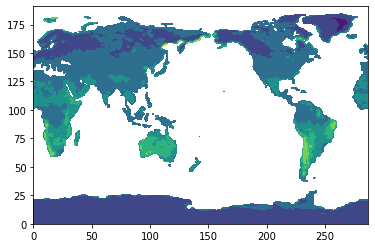

In [40]:
plt.contourf(monthlyCESM2['SHflx'].values[10,:,:]*landMask)

In [42]:
xname     = "soilM_10"
yname     = "SHflx"
averaging = "season"

# --------------------------------------------------------------
# Follow steps from Ahmed's CoMeT computation of coupling index: 
# --------------------------------------------------------------

# --- CESM 2 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CESM2)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CESM2[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CESM2[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCESM2_terra = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CESM2')


# --- CESM 1 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CESM1)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CESM1[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CESM1[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCESM1_terra = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CESM1')


# --- CLM 4.5 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CLM45)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CLM45[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CLM45[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCLM45_terra = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CLM4.5')


# --- CAM 5 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CAM5)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CAM5[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CAM5[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCAM5_terra = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CLM4.5')



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CESM2


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CESM1


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CLM4.5


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CLM4.5


In [43]:
# Save to pickle file 
dirSave        = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/'
covar_fileName = dirSave+'Covars_SM-SHF.p'

pickle.dump( [covarCESM2_terra, covarCESM1_terra, covarCLM45_terra, covarCAM5_terra], open( covar_fileName, "wb" ), protocol=4 )
print('Saved .p file for covariance data \n\n')


Saved .p file for covariance data 




In [12]:
xname     = "SHflx"
yname     = "Plcl"
averaging = "season"

# --------------------------------------------------------------
# Follow steps from Ahmed's CoMeT computation of coupling index: 
# --------------------------------------------------------------

# --- CESM 2 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CESM2)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CESM2[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CESM2[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCESM2_atmo = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CESM2')


# --- CESM 1 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CESM1)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CESM1[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CESM1[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCESM1_atmo = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CESM1')


# --- CLM 4.5 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CLM45)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CLM45[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CLM45[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCLM45_atmo = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CLM4.5')


# --- CAM 5 ----- 
# Get time axis name
time_dim = gf.get_time_axis_name(ds_CAM5)
dim  = f'{time_dim}.{averaging}'

# Make sure data are daily averages and get covariance
xday = ds_CAM5[xname].resample({time_dim:'1D'}).mean().groupby(dim)
yday = ds_CAM5[yname].resample({time_dim:'1D'}).mean().groupby(dim)
covarCAM5_atmo = gf.covariance(xday,yday,dim)
# -----------------
print('Done with CAM5')




/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CESM2


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CESM1


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CLM4.5


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Done with CLM4.5


In [13]:
# Save to pickle file 
dirSave        = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/'
covar_fileName = dirSave+'Covars_SHF-Plcl.p'

pickle.dump( [covarCESM2_atmo, covarCESM1_atmo, covarCLM45_atmo, covarCAM5_atmo], open( covar_fileName, "wb" ), protocol=4 )
print('Saved .p file for covariance data \n\n')


Saved .p file for covariance data 




### Maps? 

In [16]:
# Define lat and lon 
lat = SHflx_CAM5.lat.values
lon = SHflx_CAM5.lon.values 


<br> Plot covariance matrix (JJA) between soil moisture and sensible heat flux. 
<br><br>

In [44]:
print('Max: %.3f' % np.nanmax(covarCESM2_terra))
print('Min: %.3f' % np.nanmin(covarCESM2_terra))

Max: 960.776
Min: -343.594


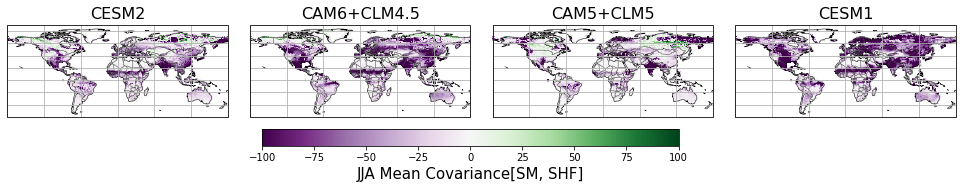

In [50]:
# Set up figure 
fig, axs = plt.subplots(1,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


cMax = 100
cMin = -cMax

# ---- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,covarCESM2_terra[1,:,:],
                             cmap='PRGn',
                             vmin=cMin,vmax=cMax)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,covarCLM45_terra[1,:,:],
                             cmap='PRGn',
                             vmin=cMin,vmax=cMax)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Covariance[SM, SHF]',fontsize=15)

# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[1].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,covarCAM5_terra[1,:,:],
                             cmap='PRGn',
                             vmin=cMin, vmax=cMax)


# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[2].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      


# Contour plots 
contour_plot = axs[3].pcolormesh(lon,lat,covarCESM1_terra[1,:,:],
                             cmap='PRGn',
                             vmin=cMin,vmax=cMax)


# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[3].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


Now plot the difference

In [51]:
covarTerra_CESM2vCESM1 = covarCESM2_terra[1,:,:] - covarCESM1_terra[1,:,:]  # Impact of upgrading CAM and CLM 
covarTerra_CESM2vCLM45 = covarCESM2_terra[1,:,:] - covarCLM45_terra[1,:,:]  # Impact of upgrading CLM
covarTerra_CESM2vCAM5  = covarCESM2_terra[1,:,:] - covarCAM5_terra[1,:,:]   # Impact of upgrading CAM 


In [52]:
print(np.nanmax(covarTerra_CESM2vCESM1))
print(np.nanmin(covarTerra_CESM2vCESM1))

318.86402421060853
-254.20500700730088


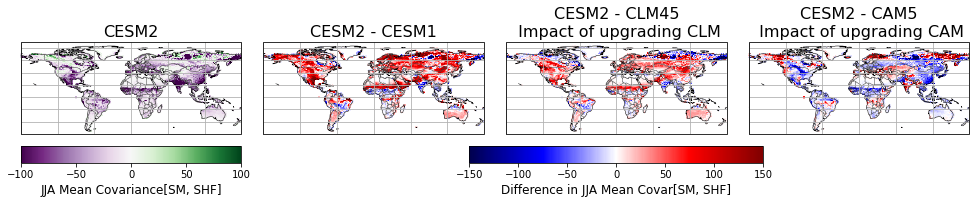

In [54]:
# Set up figure 
fig, axs = plt.subplots(1,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,covarCESM2_terra[1,:,:],
                             cmap='PRGn',
                             vmin=-100,vmax=100)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Covariance[SM, SHF]',fontsize=12)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Set color limits for difference plots 
diffMax = 150
diffMin = -diffMax

# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,covarTerra_CESM2vCESM1,
                             cmap='seismic',
                             vmin=diffMin,vmax=diffMax)


# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,covarTerra_CESM2vCLM45,
                             cmap='seismic',
                             vmin=diffMin,vmax=diffMax)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Mean Covar[SM, SHF]',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Impact of upgrading CLM',fontsize=16)
axs[2].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      


# Contour plots 
contour_plot = axs[3].pcolormesh(lon,lat,covarTerra_CESM2vCAM5,
                             cmap='seismic',
                             vmin=diffMin,vmax=diffMax)

# Additional options 
axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[3].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


<br><br> Plot covariance between SHF and P_lcl 
<br><br>

In [14]:
print('Max: %.3f' % np.nanmax(covarCESM2_atmo))
print('Min: %.3f' % np.nanmin(covarCESM2_atmo))

Max: 5348.745
Min: -4119.094


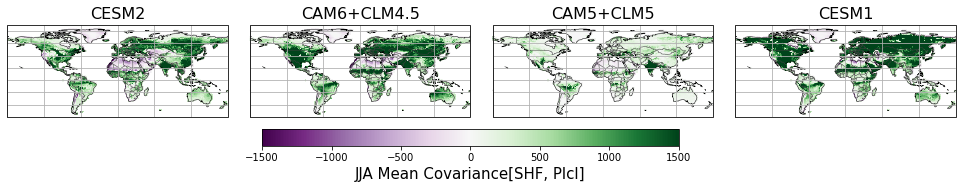

In [21]:
# Set up figure 
fig, axs = plt.subplots(1,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


cMax = 1500
cMin = -cMax

# ---- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,covarCESM2_atmo[1,:,:]*landMask,
                             cmap='PRGn',
                             vmin=cMin,vmax=cMax)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,covarCLM45_atmo[1,:,:]*landMask,
                             cmap='PRGn',
                             vmin=cMin,vmax=cMax)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Covariance[SHF, Plcl]',fontsize=15)

# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[1].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,covarCAM5_atmo[1,:,:]*landMask,
                             cmap='PRGn',
                             vmin=cMin, vmax=cMax)


# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[2].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      


# Contour plots 
contour_plot = axs[3].pcolormesh(lon,lat,covarCESM1_atmo[1,:,:]*landMask,
                             cmap='PRGn',
                             vmin=cMin,vmax=cMax)


# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[3].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



Now plot the difference 

In [22]:
covarAtmo_CESM2vCESM1 = covarCESM2_atmo[1,:,:] - covarCESM1_atmo[1,:,:]  # Impact of upgrading CAM and CLM 
covarAtmo_CESM2vCLM45 = covarCESM2_atmo[1,:,:] - covarCLM45_atmo[1,:,:]  # Impact of upgrading CLM
covarAtmo_CESM2vCAM5  = covarCESM2_atmo[1,:,:] - covarCAM5_atmo[1,:,:]   # Impact of upgrading CAM 



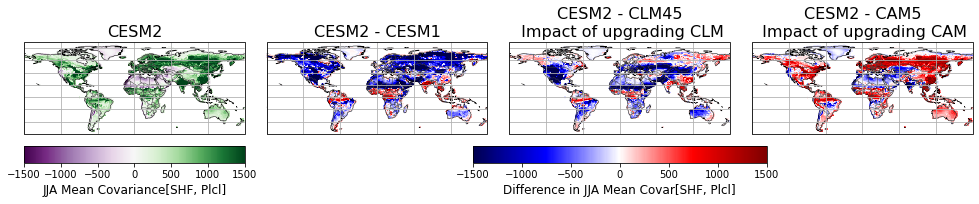

In [25]:
# Set up figure 
fig, axs = plt.subplots(1,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,covarCESM2_atmo[1,:,:]*landMask,
                             cmap='PRGn',
                             vmin=-1500,vmax=1500)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Covariance[SHF, Plcl]',fontsize=12)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Set color limits for difference plots 
diffMax = 1500
diffMin = -diffMax

# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,covarAtmo_CESM2vCESM1*landMask,
                             cmap='seismic',
                             vmin=diffMin,vmax=diffMax)


# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,covarAtmo_CESM2vCLM45*landMask,
                             cmap='seismic',
                             vmin=diffMin,vmax=diffMax)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Mean Covar[SHF, Plcl]',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Impact of upgrading CLM',fontsize=16)
axs[2].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      


# Contour plots 
contour_plot = axs[3].pcolormesh(lon,lat,covarAtmo_CESM2vCAM5*landMask,
                             cmap='seismic',
                             vmin=diffMin,vmax=diffMax)

# Additional options 
axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[3].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



### Make some maps of differences in raw variables 

In [5]:
# If reading from work laptop...
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/'

CESM2_fileName = dataDir+'CESM2_CI_variables-SHFLX_SM_Plcl.p'
CESM1_fileName = dataDir+'CESM1_CI_variables-SHFLX_SM_Plcl.p'
CLM45_fileName = dataDir+'CLM45_CI_variables-SHFLX_SM_Plcl.p'

# Load from pickle file 
SHflx_CESM2, soilM10_CESM2, Plcl_CESM2, dates              = pickle.load( open(CESM2_fileName,"rb"))
SHflx_CESM1, soil_11cm_CESM1, Plcl_CESM1, SHflx_CESM1_time = pickle.load( open(CESM1_fileName,"rb"))
SHflx_CLM45, soilM10_CLM45,   Plcl_CLM45, SHflx_CLM45_time = pickle.load( open(CLM45_fileName,"rb"))


In [14]:
# --- First, let's just look at JJA for everything ---
#     Make sure to use the same years too: 1980-2005 

# CESM2
iJJA_CESM2    = np.where((dates.month>=6) & (dates.month<=8) &
                        (dates.year>=1980) & (dates.year<=2005))[0]
SHflx_JJA_CESM2   = SHflx_CESM2[iJJA_CESM2,:,:]
soilM10_JJA_CESM2 = soilM10_CESM2[iJJA_CESM2,:,:]
Plcl_JJA_CESM2    = Plcl_CESM2[iJJA_CESM2,:,:]
dates_CESM2       = dates[iJJA_CESM2]

# CESM1
dates_CESM1   = pd.DatetimeIndex(SHflx_CESM1_time.values)
iJJA_CESM1    = np.where((dates_CESM1.month>=6) & (dates_CESM1.month<=8) &
                        (dates_CESM1.year>=1980) & (dates_CESM1.year<=2005))[0]
SHflx_JJA_CESM1   = SHflx_CESM1[iJJA_CESM1,:,:]
soilM10_JJA_CESM1 = soil_11cm_CESM1[iJJA_CESM1,:,:]
Plcl_JJA_CESM1    = Plcl_CESM1[iJJA_CESM1,:,:]
dates_CESM1       = dates_CESM1[iJJA_CESM1]

# CLM4.5 
dates_CLM45       = pd.DatetimeIndex(SHflx_CLM45_time.values)
iJJA_CLM45        = np.where((dates_CLM45.month>=6) & (dates_CLM45.month<=8))[0]
SHflx_JJA_CLM45   = SHflx_CLM45[iJJA_CLM45,:,:]
soilM10_JJA_CLM45 = soilM10_CLM45[iJJA_CLM45,:,:]
Plcl_JJA_CLM45    = Plcl_CLM45[iJJA_CLM45,:,:]
dates_CLM45       = dates_CLM45[iJJA_CLM45]

# # CAM5 
# dates_CAM5    = pd.DatetimeIndex(SHflx_CAM5['time'].values)
# iJJA_CAM5     = np.where((dates_CAM5.month>=6) & (dates_CAM5.month<=8))[0]
# SHflx_JJA_CAM5    = SHflx_CAM5.values[iJJA_CAM5,:,:]
# soilM10_JJA_CAM5  = soilM_10cm_CAM5.values[iJJA_CAM5,:,:]
# Plcl_JJA_CAM5     = Plcl_CAM5[iJJA_CAM5,:,:]


In [44]:
# Also deal with monthly data for CESM2 
dates_CESM2mon   = pd.DatetimeIndex(monthlyCESM2.time.values)
iJJA_CESM2mon    = np.where((dates_CESM2mon.month>=6) & (dates_CESM2mon.month<=8) &
                        (dates_CESM2mon.year>=1980) & (dates_CESM2mon.year<=2005))[0]

SHflx_JJA_CESM2mon = monthlyCESM2.SHflx.values[iJJA_CESM2mon,:,:]


### Better way to look at standard deviation is first removing daily climatology 

In [13]:
np.shape(SHflx_JJA_CESM2)

(2392, 192, 288)

In [12]:
len(lat)

192

In [63]:
# Months and days per month 
monSel = np.asarray([6,   7,  8])
daySel = np.asarray([30, 31, 31])

# Empty array to save daily climo and the climo-removed data 
SHFLX_dailyClimo_CESM2   = np.full([92, len(lat), len(lon)], np.nan)
soilM10_dailyClimo_CESM2 = np.full([92, len(lat), len(lon)], np.nan)
SHFLX_dailyClimo_CESM1   = np.full([92, len(lat), len(lon)], np.nan)
soilM10_dailyClimo_CESM1 = np.full([92, len(lat), len(lon)], np.nan)
SHFLX_dailyClimo_CLM45   = np.full([92, len(lat), len(lon)], np.nan)
soilM10_dailyClimo_CLM45 = np.full([92, len(lat), len(lon)], np.nan)

climoRemoved_SHFLX_CESM2 = np.full([np.shape(SHflx_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SoilM_CESM2 = np.full([np.shape(soilM10_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SHFLX_CESM1 = np.full([np.shape(SHflx_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SoilM_CESM1 = np.full([np.shape(soilM10_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SHFLX_CLM45 = np.full([np.shape(SHflx_JJA_CESM2)[0], len(lat), len(lon)], np.nan)
climoRemoved_SoilM_CLM45 = np.full([np.shape(soilM10_JJA_CESM2)[0], len(lat), len(lon)], np.nan)

# Let's also save std for each day 
dailySTD_SHFLX_CESM2     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SoilM_CESM2     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SHFLX_CESM1     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SoilM_CESM1     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SHFLX_CLM45     = np.full([92, len(lat), len(lon)], np.nan)
dailySTD_SoilM_CLM45     = np.full([92, len(lat), len(lon)], np.nan)

dayCounter = 0
for iMon in range(len(monSel)):
    for iDay in range(daySel[iMon]):
        # Pick out all days from this month in record 
        iSel_CESM2 = np.where((dates_CESM2.month==monSel[iMon]) & (dates_CESM2.day==(iDay+1)))[0]
        iSel_CESM1 = np.where((dates_CESM1.month==monSel[iMon]) & (dates_CESM1.day==(iDay+1)))[0]
        iSel_CLM45 = np.where((dates_CLM45.month==monSel[iMon]) & (dates_CLM45.day==(iDay+1)))[0]
        
        # Compute daily climo 
        dayClimo_SHflx_CESM2 = np.nanmean(SHflx_JJA_CESM2[iSel_CESM2,:,:],   axis=0)
        dayClimo_SoilM_CESM2 = np.nanmean(soilM10_JJA_CESM2[iSel_CESM2,:,:], axis=0)
        dayClimo_SHflx_CESM1 = np.nanmean(SHflx_JJA_CESM1[iSel_CESM1,:,:],   axis=0)
        dayClimo_SoilM_CESM1 = np.nanmean(soilM10_JJA_CESM1[iSel_CESM1,:,:], axis=0)
        dayClimo_SHflx_CLM45 = np.nanmean(SHflx_JJA_CLM45[iSel_CLM45,:,:],   axis=0)
        dayClimo_SoilM_CLM45 = np.nanmean(soilM10_JJA_CLM45[iSel_CLM45,:,:], axis=0)
        
        # Save to file 
        SHFLX_dailyClimo_CESM2[dayCounter,:,:]   = dayClimo_SHflx_CESM2
        soilM10_dailyClimo_CESM2[dayCounter,:,:] = dayClimo_SoilM_CESM2
        SHFLX_dailyClimo_CESM1[dayCounter,:,:]   = dayClimo_SHflx_CESM1
        soilM10_dailyClimo_CESM1[dayCounter,:,:] = dayClimo_SoilM_CESM1
        SHFLX_dailyClimo_CLM45[dayCounter,:,:]   = dayClimo_SHflx_CLM45
        soilM10_dailyClimo_CLM45[dayCounter,:,:] = dayClimo_SoilM_CLM45
        
        # Remove climatology from record 
        for iSubtract in range(len(iSel_CESM2)):
            climoRemoved_SHFLX_CESM2[iSel_CESM2[iSubtract],:,:] = SHflx_JJA_CESM2[iSel_CESM2[iSubtract],:,:] - dayClimo_SHflx_CESM2
            climoRemoved_SoilM_CESM2[iSel_CESM2[iSubtract],:,:] = soilM10_JJA_CESM2[iSel_CESM2[iSubtract],:,:] - dayClimo_SoilM_CESM2
        for iSubtract in range(len(iSel_CESM1)):
            climoRemoved_SHFLX_CESM1[iSel_CESM1[iSubtract],:,:] = SHflx_JJA_CESM1[iSel_CESM1[iSubtract],:,:] - dayClimo_SHflx_CESM1
            climoRemoved_SoilM_CESM1[iSel_CESM1[iSubtract],:,:] = soilM10_JJA_CESM1[iSel_CESM1[iSubtract],:,:] - dayClimo_SoilM_CESM1
        for iSubtract in range(len(iSel_CLM45)):
            climoRemoved_SHFLX_CLM45[iSel_CLM45[iSubtract],:,:] = SHflx_JJA_CLM45[iSel_CLM45[iSubtract],:,:] - dayClimo_SHflx_CLM45
            climoRemoved_SoilM_CLM45[iSel_CLM45[iSubtract],:,:] = soilM10_JJA_CLM45[iSel_CLM45[iSubtract],:,:] - dayClimo_SoilM_CLM45
            
        # Save std of each JJA day 
        dailySTD_SHFLX_CESM2[dayCounter,:,:] = np.nanstd(SHflx_JJA_CESM2[iSel_CESM2,:,:],   axis=0)
        dailySTD_SoilM_CESM2[dayCounter,:,:] = np.nanstd(soilM10_JJA_CESM2[iSel_CESM2,:,:], axis=0)
        dailySTD_SHFLX_CESM1[dayCounter,:,:] = np.nanstd(SHflx_JJA_CESM1[iSel_CESM1,:,:],   axis=0)
        dailySTD_SoilM_CESM1[dayCounter,:,:] = np.nanstd(soilM10_JJA_CESM1[iSel_CESM1,:,:], axis=0)
        dailySTD_SHFLX_CLM45[dayCounter,:,:] = np.nanstd(SHflx_JJA_CLM45[iSel_CLM45,:,:],   axis=0)
        dailySTD_SoilM_CLM45[dayCounter,:,:] = np.nanstd(soilM10_JJA_CLM45[iSel_CLM45,:,:], axis=0)

        # Increment day of JJA counter
        dayCounter = dayCounter+1


<ipython-input-63-02d508c8ef45>:38: RuntimeWarning: Mean of empty slice
  dayClimo_SoilM_CESM2 = np.nanmean(soilM10_JJA_CESM2[iSel_CESM2,:,:], axis=0)
<ipython-input-63-02d508c8ef45>:40: RuntimeWarning: Mean of empty slice
  dayClimo_SoilM_CESM1 = np.nanmean(soilM10_JJA_CESM1[iSel_CESM1,:,:], axis=0)
<ipython-input-63-02d508c8ef45>:42: RuntimeWarning: Mean of empty slice
  dayClimo_SoilM_CLM45 = np.nanmean(soilM10_JJA_CLM45[iSel_CLM45,:,:], axis=0)
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [65]:
print('Mean of JJA daily std:    %.5f ' % np.nanmean(dailySTD_SHFLX_CESM2[:, 133, 203]))
print('Std of JJA climo removed: %.5f' % np.nanstd(climoRemoved_SHFLX_CESM2[:,133,203], axis=0))


Mean of JJA daily std:    22.90196 
Std of JJA climo removed: 23.13405


Text(0.5, 1.0, 'CESM2: Sanity check on daily climo removal')

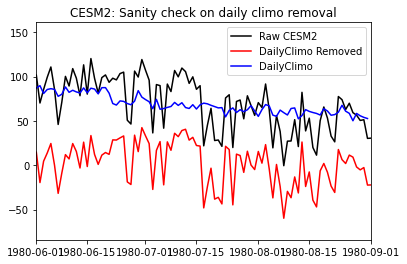

In [61]:
# Quick plot to confirm that this *is* working about how I think it should

plt.plot(dates_CESM2, SHflx_JJA_CESM2[:,133,203], 'k-')
plt.plot(dates_CESM2, climoRemoved_SHFLX_CESM2[:,133,203], 'r-')
plt.plot(dates_CESM2[0:92],SHFLX_dailyClimo_CESM2[:,133,203],'b-')
plt.xlim([datetime.date(1980,6,1), datetime.date(1980,9,1)])
plt.legend(['Raw CESM2', 'DailyClimo Removed', 'DailyClimo'])
plt.title('CESM2: Sanity check on daily climo removal')


Text(0.5, 1.0, 'CESM2: Sanity check on daily climo removal')

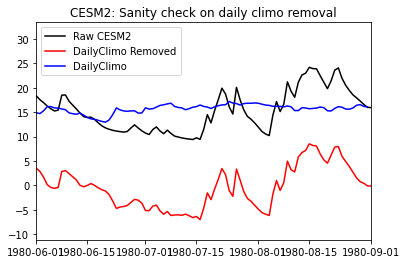

In [60]:
# Quick plot to confirm that this *is* working about how I think it should

plt.plot(dates_CESM2, soilM10_JJA_CESM2[:,133,203], 'k-')
plt.plot(dates_CESM2, climoRemoved_SoilM_CESM2[:,133,203], 'r-')
plt.plot(dates_CESM2[0:92],soilM10_dailyClimo_CESM2[:,133,203],'b-')
plt.xlim([datetime.date(1980,6,1), datetime.date(1980,9,1)])
plt.legend(['Raw CESM2', 'DailyClimo Removed', 'DailyClimo'])
plt.title('CESM2: Sanity check on daily climo removal')


### Now do some calculations

In [28]:
# print(min(dates),      '   -    ',max(dates))
# print(min(dates_CESM1),'   -    ',max(dates_CESM1))
# print(min(dates_CLM45),'   -    ',max(dates_CLM45))
# print(min(dates_CAM5), '   -    ',max(dates_CAM5))


1979-01-01 00:00:00    -     2006-12-31 00:00:00
1979-01-01 00:00:00    -     2006-11-01 00:00:00
1980-01-11 00:00:00    -     2006-01-01 00:00:00
1980-02-01 00:00:00    -     2006-01-01 00:00:00


In [67]:
# Now get mean and std of soil moisture and sensible heat flux 
SM_JJAmean_CESM2 = np.nanmean(soilM10_JJA_CESM2, axis=0)
SM_JJAmean_CESM1 = np.nanmean(soilM10_JJA_CESM1, axis=0)
SM_JJAmean_CLM45 = np.nanmean(soilM10_JJA_CLM45, axis=0)
#SM_JJAmean_CAM5  = np.nanmean(soilM10_JJA_CAM5,  axis=0)

SH_JJAmean_CESM2 = np.nanmean(SHflx_JJA_CESM2, axis=0)
SH_JJAmean_CESM1 = np.nanmean(SHflx_JJA_CESM1, axis=0)
SH_JJAmean_CLM45 = np.nanmean(SHflx_JJA_CLM45, axis=0)
#SH_JJAmean_CAM5  = np.nanmean(SHflx_JJA_CAM5,  axis=0)

# For std especially, remove daily climatology from data 
SM_JJAstd_CESM2  = np.nanstd(climoRemoved_SoilM_CESM2, axis=0)
SM_JJAstd_CESM1  = np.nanstd(climoRemoved_SoilM_CESM1, axis=0)
SM_JJAstd_CLM45  = np.nanstd(climoRemoved_SoilM_CLM45, axis=0)

SH_JJAstd_CESM2  = np.nanstd(climoRemoved_SHFLX_CESM2, axis=0)
SH_JJAstd_CESM1  = np.nanstd(climoRemoved_SHFLX_CESM1, axis=0)
SH_JJAstd_CLM45  = np.nanstd(climoRemoved_SHFLX_CLM45, axis=0)

# SM_JJAstd_CESM2  = np.nanstd(soilM10_JJA_CESM2, axis=0)
# SM_JJAstd_CESM1  = np.nanstd(soilM10_JJA_CESM1, axis=0)
# SM_JJAstd_CLM45  = np.nanstd(soilM10_JJA_CLM45, axis=0)
# SM_JJAstd_CAM5   = np.nanstd(soilM10_JJA_CAM5,  axis=0)

# SH_JJAstd_CESM2  = np.nanstd(SHflx_JJA_CESM2, axis=0)
# SH_JJAstd_CESM1  = np.nanstd(SHflx_JJA_CESM1, axis=0)
# SH_JJAstd_CLM45  = np.nanstd(SHflx_JJA_CLM45, axis=0)
# SH_JJAstd_CAM5   = np.nanstd(SHflx_JJA_CAM5,  axis=0)

# Also do for monthly CESM2... 
# SH_JJAmean_CESM2mon = np.nanmean(SHflx_JJA_CESM2mon, axis=0)
# SH_JJAstd_CESM2mon  = np.nanstd(SHflx_JJA_CESM2mon, axis=0)


<ipython-input-67-a55a28fdf425>:2: RuntimeWarning: Mean of empty slice
  SM_JJAmean_CESM2 = np.nanmean(soilM10_JJA_CESM2, axis=0)
<ipython-input-67-a55a28fdf425>:3: RuntimeWarning: Mean of empty slice
  SM_JJAmean_CESM1 = np.nanmean(soilM10_JJA_CESM1, axis=0)
<ipython-input-67-a55a28fdf425>:4: RuntimeWarning: Mean of empty slice
  SM_JJAmean_CLM45 = np.nanmean(soilM10_JJA_CLM45, axis=0)


In [79]:
# Save climo-removed SHFLX to pickle file 
dirSave        = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
noClimo_SHF_fileName = dirSave+'SHF-DailyClimoRemoved.p'

pickle.dump( [climoRemoved_SHFLX_CESM2, climoRemoved_SHFLX_CESM1, climoRemoved_SHFLX_CLM45], open( noClimo_SHF_fileName, "wb" ), protocol=4 )
print('Saved .p file for data without daily climo \n\n')

# Save climo-removed SoilM to pickle file
noClimo_SoilM_fileName = dirSave+'SoilM-DailyClimoRemoved.p'

pickle.dump( [climoRemoved_SoilM_CESM2, climoRemoved_SoilM_CESM1, climoRemoved_SoilM_CLM45], open( noClimo_SoilM_fileName, "wb" ), protocol=4 )
print('Saved .p file for data without daily climo \n\n')


Saved .p file for data without daily climo 


Saved .p file for data without daily climo 




In [72]:
#Compute land mask  
lndMask = np.full([len(lat),len(lon)],np.nan)
lndMask[np.where(np.isfinite(SM_JJAmean_CESM2))] = 1 


In [104]:
# # Save means and std's of JJA SM and SH out to pickle file 
# SM_JJA_fileName = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/SoilM_JJA_Mean&std.p'
# pickle.dump( [SM_JJAmean_CESM2, SM_JJAmean_CESM1, SM_JJAmean_CLM45, SM_JJAmean_CAM5,
#               SM_JJAstd_CESM2, SM_JJAstd_CESM1, SM_JJAstd_CLM45, SM_JJAstd_CAM5], 
#               open( SM_JJA_fileName, "wb" ), protocol=4 )
# print('Saved .p file for soil moisture data \n')


# SH_JJA_fileName = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/SHFLX_JJA_Mean&std.p'
# pickle.dump( [SH_JJAmean_CESM2, SH_JJAmean_CESM1, SH_JJAmean_CLM45, SH_JJAmean_CAM5,
#               SH_JJAstd_CESM2,  SH_JJAstd_CESM1,  SH_JJAstd_CLM45,  SH_JJAstd_CAM5], 
#               open( SH_JJA_fileName, "wb" ), protocol=4 )
# print('Saved .p file for shflx data \n')



Saved .p file for soil moisture data 

Saved .p file for shflx data 



**Start with plots of SM mean and std**

In [62]:
# Define lat and lon 
lat = SHflx_CAM5.lat.values
lon = SHflx_CAM5.lon.values 


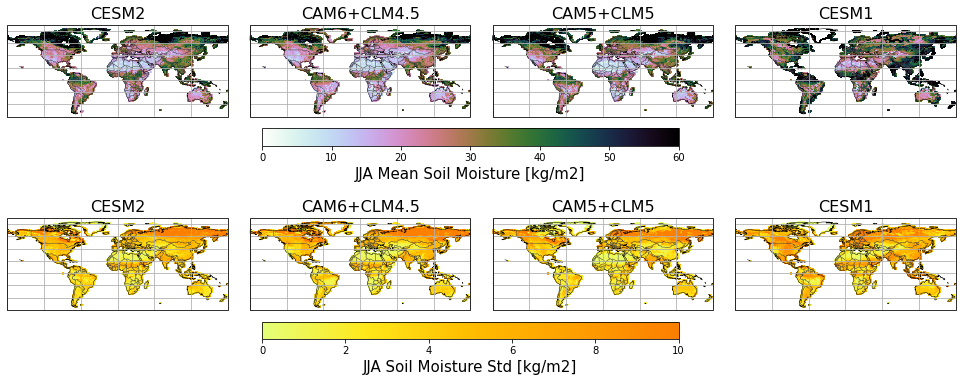

In [69]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()



# ---- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,SM_JJAmean_CESM2,
                             cmap='cubehelix_r',
                             vmin=0,vmax=60)

contour_plot = axs[4].pcolormesh(lon,lat,SM_JJAstd_CESM2,
                             cmap='Wistia',
                             vmin=0,vmax=10)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,SM_JJAmean_CLM45,
                             cmap='cubehelix_r',
                             vmin=0,vmax=60)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Soil Moisture [kg/m2]',fontsize=15)


contour_plot = axs[5].pcolormesh(lon,lat,SM_JJAstd_CLM45,
                             cmap='Wistia',
                             vmin=0,vmax=10)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Soil Moisture Std [kg/m2]',fontsize=15)


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[5].set_title('CAM6+CLM4.5',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,SM_JJAmean_CAM5,
                             cmap='cubehelix_r',
                             vmin=0, vmax=60)

contour_plot = axs[6].pcolormesh(lon,lat,SM_JJAstd_CAM5,
                             cmap='Wistia',
                             vmin=0,vmax=10)

# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[6].set_title('CAM5+CLM5',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
contour_plot = axs[3].pcolormesh(lon,lat,SM_JJAmean_CESM1,
                             cmap='cubehelix_r',
                             vmin=0,vmax=60)

contour_plot = axs[7].pcolormesh(lon,lat,SM_JJAstd_CESM1,
                             cmap='Wistia',
                             vmin=0,vmax=10)

# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[7].set_title('CESM1',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


**Also plot mean and std of SHFLX**

In [75]:
print(np.nanmin(SH_JJAstd_CESM2))
print(np.nanmin(SH_JJAstd_CESM1))
print(np.nanmin(SH_JJAstd_CLM45))
print(np.nanmin(SH_JJAstd_CAM5))
print()
print(np.nanmax(SH_JJAstd_CESM2))
print(np.nanmax(SH_JJAstd_CESM1))
print(np.nanmax(SH_JJAstd_CLM45))
print(np.nanmax(SH_JJAstd_CAM5))
print()
print(np.nanmean(SH_JJAstd_CESM2))
print(np.nanmean(SH_JJAstd_CESM1))
print(np.nanmean(SH_JJAstd_CLM45))
print(np.nanmean(SH_JJAstd_CAM5))

1.9824294
1.7927082
2.075535
0.7534481

112.30126
109.187965
109.65549
90.13832

17.381498
17.197578
17.57363
7.12673


In [71]:
print(np.nanmin(SH_JJAmean_CESM2))
print(np.nanmin(SH_JJAmean_CESM1))
print(np.nanmin(SH_JJAmean_CLM45))
print(np.nanmin(SH_JJAmean_CAM5))
print()
print(np.nanmax(SH_JJAmean_CESM2))
print(np.nanmax(SH_JJAmean_CESM1))
print(np.nanmax(SH_JJAmean_CLM45))
print(np.nanmax(SH_JJAmean_CAM5))
print()
print(np.nanmean(SH_JJAmean_CESM2))
print(np.nanmean(SH_JJAmean_CESM1))
print(np.nanmean(SH_JJAmean_CLM45))
print(np.nanmean(SH_JJAmean_CAM5))

-63.588238
-49.128407
-61.73158
-57.524315

173.02824
147.87997
169.1263
195.7434

16.680397
15.477142
16.561117
15.316773


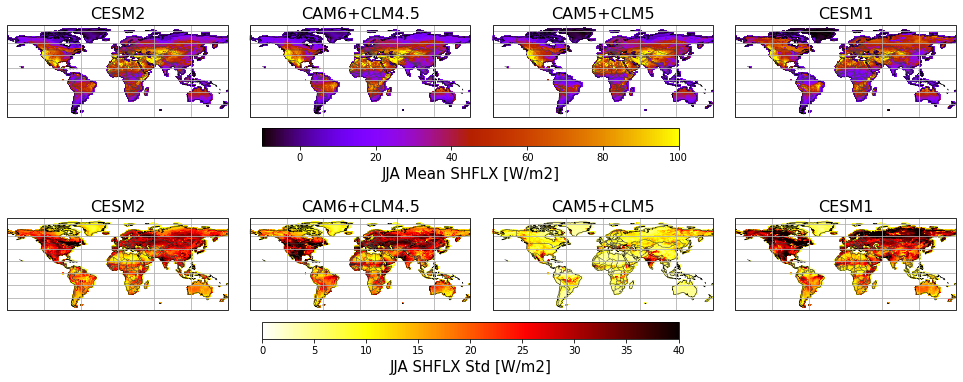

In [82]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()



# ---- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,SH_JJAmean_CESM2*landMask,
                             cmap='gnuplot',
                             vmin=-10,vmax=100)

contour_plot = axs[4].pcolormesh(lon,lat,SH_JJAstd_CESM2*landMask,
                             cmap='hot_r',
                             vmin=0,vmax=40)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,SH_JJAmean_CLM45*landMask,
                             cmap='gnuplot',
                             vmin=-10,vmax=100)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean SHFLX [W/m2]',fontsize=15)


contour_plot = axs[5].pcolormesh(lon,lat,SH_JJAstd_CLM45*landMask,
                             cmap='hot_r',
                             vmin=0,vmax=40)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA SHFLX Std [W/m2]',fontsize=15)


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[5].set_title('CAM6+CLM4.5',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,SH_JJAmean_CAM5*landMask,
                             cmap='gnuplot',
                             vmin=-10, vmax=100)

contour_plot = axs[6].pcolormesh(lon,lat,SH_JJAstd_CAM5*landMask,
                             cmap='hot_r',
                             vmin=0,vmax=40)

# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[6].set_title('CAM5+CLM5',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
contour_plot = axs[3].pcolormesh(lon,lat,SH_JJAmean_CESM1*landMask,
                             cmap='gnuplot',
                             vmin=-10,vmax=100)

contour_plot = axs[7].pcolormesh(lon,lat,SH_JJAstd_CESM1*landMask,
                             cmap='hot_r',
                             vmin=0,vmax=40)

# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[7].set_title('CESM1',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



### Difference plots 

In [69]:
# ---- Soil Moisture -----
SMmean_CESM2vCESM1 = SM_JJAmean_CESM2 - SM_JJAmean_CESM1  # Impact of upgrading CAM and CLM 
SMmean_CESM2vCLM45 = SM_JJAmean_CESM2 - SM_JJAmean_CLM45  # Impact of upgrading CLM
#SMmean_CESM2vCAM5  = SM_JJAmean_CESM2 - SM_JJAmean_CAM5   # Impact of upgrading CAM 

SMstd_CESM2vCESM1 = SM_JJAstd_CESM2 - SM_JJAstd_CESM1 # Impact of upgrading CAM and CLM  
SMstd_CESM2vCLM45 = SM_JJAstd_CESM2 - SM_JJAstd_CLM45 # Impact of upgrading CLM 
#SMstd_CESM2vCAM5  = SM_JJAstd_CESM2 - SM_JJAstd_CAM5  # Impact of upgrading CAM

# ---- SHFLX -----
SHmean_CESM2vCESM1 = SH_JJAmean_CESM2 - SH_JJAmean_CESM1  # Impact of upgrading CAM and CLM 
SHmean_CESM2vCLM45 = SH_JJAmean_CESM2 - SH_JJAmean_CLM45  # Impact of upgrading CLM
#SHmean_CESM2vCAM5  = SH_JJAmean_CESM2 - SH_JJAmean_CAM5   # Impact of upgrading CAM 

SHstd_CESM2vCESM1 = SH_JJAstd_CESM2 - SH_JJAstd_CESM1 # Impact of upgrading CAM and CLM  
SHstd_CESM2vCLM45 = SH_JJAstd_CESM2 - SH_JJAstd_CLM45 # Impact of upgrading CLM 
#SHstd_CESM2vCAM5  = SH_JJAstd_CESM2 - SH_JJAstd_CAM5  # Impact of upgrading CAM
#SHstd_CESM2monvCAM5 = SH_JJAstd_CESM2mon - SH_JJAstd_CAM5 # Impact on *monthly* std of SH 


In [47]:
# CRAZY std differences for CESM2 - CAM5 .... 
print(np.nanmean(SH_JJAstd_CESM2*landMask))
print(np.nanmean(SH_JJAstd_CAM5*landMask))
print(np.nanmean(SH_JJAstd_CESM2mon*landMask))


18.11392645917456
7.78244149890273
7.707189534818781


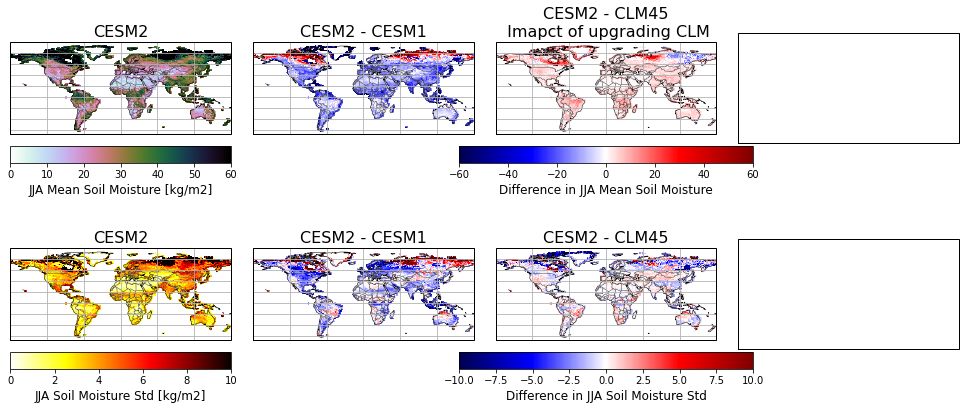

In [70]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,SM_JJAmean_CESM2,
                             cmap='cubehelix_r',
                             vmin=0,vmax=60)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Soil Moisture [kg/m2]',fontsize=12)


contour_plot = axs[4].pcolormesh(lon,lat,SM_JJAstd_CESM2,
                             cmap='hot_r',
                             vmin=0,vmax=10)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Soil Moisture Std [kg/m2]',fontsize=12)


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,SMmean_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-60,vmax=60)
contour_plot = axs[5].pcolormesh(lon,lat,SMstd_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-10,vmax=10)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,SMmean_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-60,vmax=60)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Mean Soil Moisture',fontsize=12)


contour_plot = axs[6].pcolormesh(lon,lat,SMstd_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-10,vmax=10)

# Add colorbar 
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Soil Moisture Std',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# # ----- Plot impact of upgrading just CAM------ 
# #   ...Diff_CESM2vCAM5
# # Set global-ish extent
# axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
# axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# # Contour plots 
# contour_plot = axs[3].pcolormesh(lon,lat,SMmean_CESM2vCAM5,
#                              cmap='seismic',
#                              vmin=-60,vmax=60)

# contour_plot = axs[7].pcolormesh(lon,lat,SMstd_CESM2vCAM5,
#                              cmap='seismic',
#                              vmin=-10,vmax=10)

# # Additional options 
# axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
# axs[7].set_title('CESM2 - CAM5',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
# axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


In [34]:
np.nanmean(SHstd_CESM2vCAM5)

10.254769

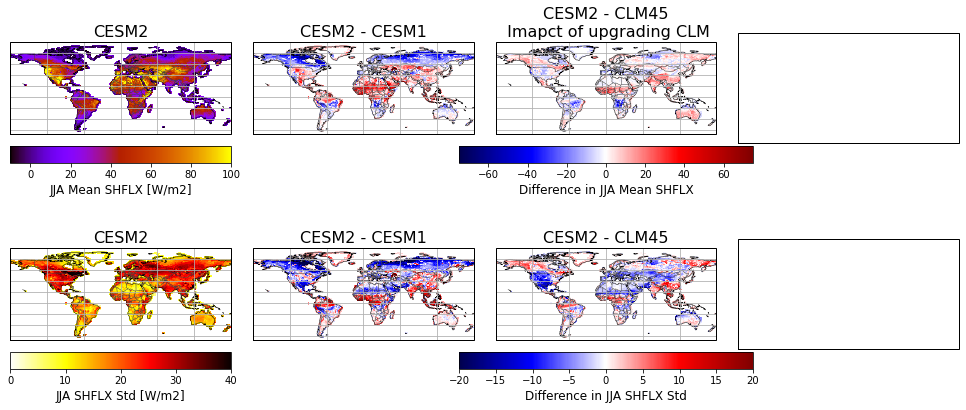

In [76]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,SH_JJAmean_CESM2*lndMask,
                             cmap='gnuplot',
                             vmin=-10,vmax=100)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean SHFLX [W/m2]',fontsize=12)


contour_plot = axs[4].pcolormesh(lon,lat,SH_JJAstd_CESM2*lndMask,
                             cmap='hot_r',
                             vmin=0,vmax=40)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA SHFLX Std [W/m2]',fontsize=12)


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,SHmean_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-75,vmax=75)
contour_plot = axs[5].pcolormesh(lon,lat,SHstd_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-20,vmax=20)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,SHmean_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-75,vmax=75)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Mean SHFLX',fontsize=12)


contour_plot = axs[6].pcolormesh(lon,lat,SHstd_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-20,vmax=20)

# Add colorbar 
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA SHFLX Std',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# # ----- Plot impact of upgrading just CAM------ 
# #   ...Diff_CESM2vCAM5
# # Set global-ish extent
# axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
# axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# # Contour plots 
# contour_plot = axs[3].pcolormesh(lon,lat,SHmean_CESM2vCAM5*landMask,
#                              cmap='seismic',
#                              vmin=-75,vmax=75)

# #contour_plot = axs[7].pcolormesh(lon,lat,SHstd_CESM2vCAM5*landMask,
# contour_plot = axs[7].pcolormesh(lon,lat,SHstd_CESM2monvCAM5*landMask,
#                              cmap='seismic',
#                              vmin=-20,vmax=20)

# # Additional options 
# axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
# axs[7].set_title('CESM2 - CAM5',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
# axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



In [74]:
## Just as a sanity check - does it matter if std is computed as above, 
#    or as std per day, averaged over JJA? 

# For std especially, remove daily climatology from data 
SM_JJAstdTest_CESM2  = np.nanmean(dailySTD_SoilM_CESM2, axis=0)
SM_JJAstdTest_CESM1  = np.nanmean(dailySTD_SoilM_CESM1, axis=0)
SM_JJAstdTest_CLM45  = np.nanmean(dailySTD_SoilM_CLM45, axis=0)

SH_JJAstdTest_CESM2  = np.nanmean(dailySTD_SHFLX_CESM2, axis=0)
SH_JJAstdTest_CESM1  = np.nanmean(dailySTD_SHFLX_CESM1, axis=0)
SH_JJAstdTest_CLM45  = np.nanmean(dailySTD_SHFLX_CLM45, axis=0)


<ipython-input-74-430860f9b667>:5: RuntimeWarning: Mean of empty slice
  SM_JJAstdTest_CESM2  = np.nanmean(dailySTD_SoilM_CESM2, axis=0)
<ipython-input-74-430860f9b667>:6: RuntimeWarning: Mean of empty slice
  SM_JJAstdTest_CESM1  = np.nanmean(dailySTD_SoilM_CESM1, axis=0)
<ipython-input-74-430860f9b667>:7: RuntimeWarning: Mean of empty slice
  SM_JJAstdTest_CLM45  = np.nanmean(dailySTD_SoilM_CLM45, axis=0)


In [75]:
# Get differences of std using alternative method 
SMstdTest_CESM2vCESM1 = SM_JJAstdTest_CESM2 - SM_JJAstdTest_CESM1 # Impact of upgrading CAM and CLM  
SMstdTest_CESM2vCLM45 = SM_JJAstdTest_CESM2 - SM_JJAstdTest_CLM45 # Impact of upgrading CLM 

SHstdTest_CESM2vCESM1 = SH_JJAstdTest_CESM2 - SH_JJAstdTest_CESM1 # Impact of upgrading CAM and CLM  
SHstdTest_CESM2vCLM45 = SH_JJAstdTest_CESM2 - SH_JJAstdTest_CLM45 # Impact of upgrading CLM 


**Make maps of std differences**

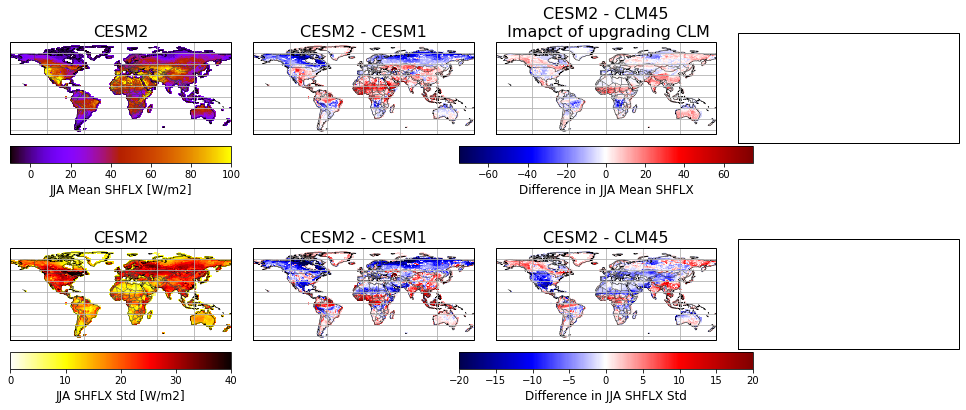

In [77]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,SH_JJAmean_CESM2*lndMask,
                             cmap='gnuplot',
                             vmin=-10,vmax=100)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean SHFLX [W/m2]',fontsize=12)


contour_plot = axs[4].pcolormesh(lon,lat,SH_JJAstdTest_CESM2*lndMask,
                             cmap='hot_r',
                             vmin=0,vmax=40)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA SHFLX Std [W/m2]',fontsize=12)


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,SHmean_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-75,vmax=75)
contour_plot = axs[5].pcolormesh(lon,lat,SHstdTest_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-20,vmax=20)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,SHmean_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-75,vmax=75)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Mean SHFLX',fontsize=12)


contour_plot = axs[6].pcolormesh(lon,lat,SHstdTest_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-20,vmax=20)

# Add colorbar 
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA SHFLX Std',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# # ----- Plot impact of upgrading just CAM------ 
# #   ...Diff_CESM2vCAM5
# # Set global-ish extent
# axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
# axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# # Contour plots 
# contour_plot = axs[3].pcolormesh(lon,lat,SHmean_CESM2vCAM5*landMask,
#                              cmap='seismic',
#                              vmin=-75,vmax=75)

# #contour_plot = axs[7].pcolormesh(lon,lat,SHstd_CESM2vCAM5*landMask,
# contour_plot = axs[7].pcolormesh(lon,lat,SHstd_CESM2monvCAM5*landMask,
#                              cmap='seismic',
#                              vmin=-20,vmax=20)

# # Additional options 
# axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
# axs[7].set_title('CESM2 - CAM5',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
# axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

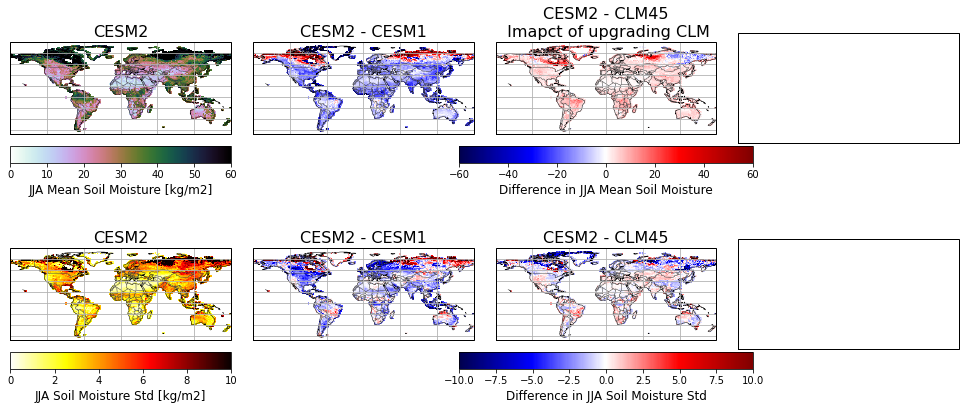

In [78]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,SM_JJAmean_CESM2,
                             cmap='cubehelix_r',
                             vmin=0,vmax=60)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Soil Moisture [kg/m2]',fontsize=12)


contour_plot = axs[4].pcolormesh(lon,lat,SM_JJAstdTest_CESM2,
                             cmap='hot_r',
                             vmin=0,vmax=10)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Soil Moisture Std [kg/m2]',fontsize=12)


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,SMmean_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-60,vmax=60)
contour_plot = axs[5].pcolormesh(lon,lat,SMstdTest_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-10,vmax=10)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,SMmean_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-60,vmax=60)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Mean Soil Moisture',fontsize=12)


contour_plot = axs[6].pcolormesh(lon,lat,SMstdTest_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-10,vmax=10)

# Add colorbar 
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in JJA Soil Moisture Std',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# # ----- Plot impact of upgrading just CAM------ 
# #   ...Diff_CESM2vCAM5
# # Set global-ish extent
# axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
# axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# # Contour plots 
# contour_plot = axs[3].pcolormesh(lon,lat,SMmean_CESM2vCAM5,
#                              cmap='seismic',
#                              vmin=-60,vmax=60)

# contour_plot = axs[7].pcolormesh(lon,lat,SMstd_CESM2vCAM5,
#                              cmap='seismic',
#                              vmin=-10,vmax=10)

# # Additional options 
# axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
# axs[7].set_title('CESM2 - CAM5',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
# axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

